# Energy/Amplitude

Parameters:
  omega0 = 3.0
  zeta   = 0.006666666666666667
  beta   = 0.04
  epsilon= 1
  alpha  = 9.0
  D      = 0.11459155902616466

Energy/FP initial condition handoff at t_init = 0.10 s
Loading Kramers Monte Carlo from data/mc_kramers_T100.0_np60000_omega3.0_beta0.04_D0.11459155902616466_Emax_40.0.pkl ...
[FULL] Loaded from file.

Calculating Full Amplitude snapshots from Energy...
Loading energy SDE Monte Carlo from data/mc_energySDE_T100.0_np60000_omega3.0_beta0.04_D0.11459155902616466.pkl ...
[E-SDE] Loaded from file.

Calculating Reduced Amplitude snapshots from Energy...
Solving eigenvalue problem...
[EIGEN] Elapsed time  = 1.01 s

Computing Spectral Evolution...
--- Generating Heatmaps (Energy & Amplitude) ---
Saved: figures/Figure_1.pdf


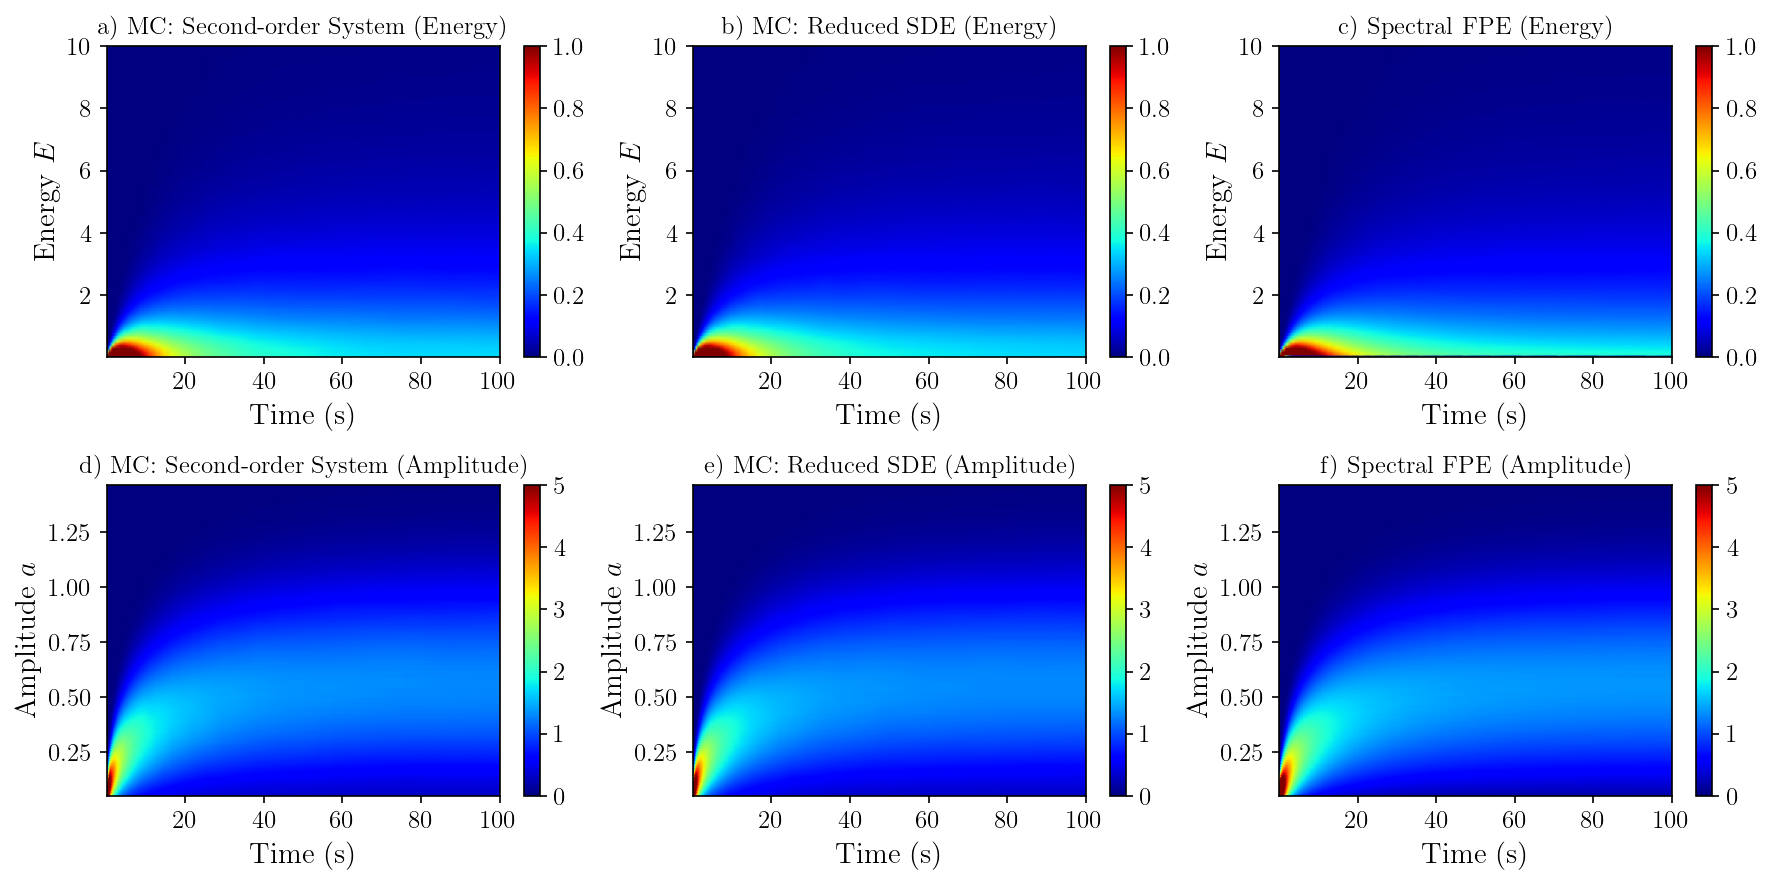

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pickle
from scipy.special import ellipk, ellipe
from scipy.stats import gaussian_kde

# =============================================================================
# Matplotlib config (LaTeX style)
# =============================================================================
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 150,
    "savefig.bbox": "tight",
})

def savefig_pdf(fname):
    if not fname.lower().endswith(".pdf"):
        fname = 'figures/' + fname + ".pdf"
    plt.savefig(fname)
    print(f"Saved: {fname}")

# =============================================================================
# 1. Duffing parameters
# =============================================================================
omega0  = 3.0
zeta    = 0.02 / omega0
beta    = 2.0 * zeta * omega0
epsilon = 1
alpha   = epsilon * omega0**2
D       = 2.0 * zeta * omega0**3 / np.pi

print("Parameters:")
print(f"  omega0 = {omega0}")
print(f"  zeta   = {zeta}")
print(f"  beta   = {beta}")
print(f"  epsilon= {epsilon}")
print(f"  alpha  = {alpha}")
print(f"  D      = {D}\n")

# =============================================================================
# 2. Time discretization and Monte Carlo setup
# =============================================================================
T       = 100.0
dt      = 1e-4
n_steps = int(T / dt)

snapshot_times = np.geomspace(0.1, T, 51) 
snapshot_times = np.insert(snapshot_times, 0, 0.0) # Add t=0
snapshot_indices = {ts: int(round(ts / dt)) for ts in snapshot_times}

n_paths = 60000
np.random.seed(1234)

t_init = 0.1
idx_init = snapshot_indices.get(t_init, int(t_init/dt))
print(f"Energy/FP initial condition handoff at t_init = {t_init:.2f} s")

# =============================================================================
# 3. Duffing potential and energy-amplitude mapping
# =============================================================================
def U(x):
    return 0.5 * omega0**2 * x**2 + 0.25 * alpha * x**4

def E_from_a(a):
    return 0.5 * omega0**2 * a**2 + 0.25 * alpha * a**4

def a_from_E(E):
    E = np.asarray(E)
    Delta = np.sqrt(omega0**4 + 4.0 * alpha * np.maximum(E, 0.0))
    a2 = (-omega0**2 + Delta) / alpha
    a2 = np.maximum(a2, 0.0)
    return np.sqrt(a2)

# =============================================================================
# 4. Energy SDE coefficients
# =============================================================================
def v2_avg_E(E):
    E = np.asarray(E, float)
    E_pos = np.maximum(E, 0.0)
    root = np.sqrt(4.0 * epsilon * E_pos + omega0**2)
    s = np.sqrt(1.0 + 4.0 * epsilon * E_pos / omega0**2)
    mE = (omega0 - root) / (omega0 + root)
    K = ellipk(mE)
    Eell = ellipe(mE)
    v2 = ((1.0 + s) * omega0**2 * (s - Eell / K)) / (3.0 * epsilon)
    return np.maximum(v2, 0.0)

def A_of_E(E):
    return D - beta * v2_avg_E(E)

def B_of_E(E):
    return 2.0 * D * v2_avg_E(E)

# =============================================================================
# 5. Energy domain
# =============================================================================
a0   = 1e-3
E0   = E_from_a(a0)
Emin = 1e-4
Emax = 40.0

# =============================================================================
# 6. Monte Carlo: full Kramers SDE (x,v)
# =============================================================================
kramers_file = f"data/mc_kramers_T{T}_np{n_paths}_omega{omega0}_beta{beta}_D{D}_Emax_{Emax}.pkl"
snapshots_E_full = {}

if os.path.exists(kramers_file):
    print(f"Loading Kramers Monte Carlo from {kramers_file} ...")
    with open(kramers_file, "rb") as f:
        data = pickle.load(f)
    snapshots_E_full = data["snapshots_E_full"]
    print("[FULL] Loaded from file.\n")
else:
    print("Starting full (x,v) Kramers simulation...")
    x = np.full((n_paths,), a0, dtype=float)
    v = np.zeros((n_paths,), dtype=float)
    snapshots_E_full = {ts: None for ts in snapshot_times}

    start = time.perf_counter()
    for i in range(n_steps):
        dW = np.sqrt(dt) * np.random.randn(n_paths)
        x += v * dt
        dUdx = omega0**2 * x + alpha * x**3
        v += (-(beta * v + dUdx)) * dt + np.sqrt(2.0 * D) * dW

        if (i + 1) in snapshot_indices.values():
            E_current = 0.5 * v**2 + U(x)
            for ts, idx in snapshot_indices.items():
                if idx == (i + 1) and snapshots_E_full[ts] is None:
                    snapshots_E_full[ts] = E_current.copy()

    end = time.perf_counter()
    print(f"[FULL] Elapsed time  = {end - start:.2f} s\n")
    
    with open(kramers_file, "wb") as f:
        pickle.dump({"snapshots_E_full": snapshots_E_full}, f)

print("Calculating Full Amplitude snapshots from Energy...")
snapshots_a_full = {}
for ts, E_vals in snapshots_E_full.items():
    if E_vals is not None:
        snapshots_a_full[ts] = a_from_E(E_vals)

# =============================================================================
# 7. Monte Carlo: energy SDE with reflecting BCs
# =============================================================================
def step_energy_reflect(E, dt):
    dW = np.sqrt(dt) * np.random.randn(*E.shape)
    A = A_of_E(E)
    B = B_of_E(E)
    E_new = E + A * dt + np.sqrt(np.maximum(B, 0.0)) * dW
    # Reflect
    mask_lower = E_new < Emin
    E_new[mask_lower] = 2.0 * Emin - E_new[mask_lower]
    mask_upper = E_new > Emax
    E_new[mask_upper] = 2.0 * Emax - E_new[mask_upper]
    return np.clip(E_new, Emin, Emax)

# Initial condition from Kramers at t_init
if t_init in snapshots_E_full and snapshots_E_full[t_init] is not None:
    E_init_from_Kramers = snapshots_E_full[t_init].copy()
else:
    closest_t = min(snapshots_E_full.keys(), key=lambda k: abs(k-t_init))
    E_init_from_Kramers = snapshots_E_full[closest_t].copy()

E_init_from_Kramers = np.clip(E_init_from_Kramers, Emin, Emax)

energy_sde_file = f"data/mc_energySDE_T{T}_np{n_paths}_omega{omega0}_beta{beta}_D{D}.pkl"
snapshots_E_sde = {}

if os.path.exists(energy_sde_file):
    print(f"Loading energy SDE Monte Carlo from {energy_sde_file} ...")
    with open(energy_sde_file, "rb") as f:
        data_sde = pickle.load(f)
    snapshots_E_sde = data_sde["snapshots_E_sde"]
    print("[E-SDE] Loaded from file.\n")
else:
    E_sde = E_init_from_Kramers.copy()
    snapshots_E_sde = {ts: None for ts in snapshot_times}
    snapshots_E_sde[t_init] = E_sde.copy()

    print("Starting energy SDE simulation...")
    start = time.perf_counter()
    for i in range(idx_init, n_steps):
        E_sde = step_energy_reflect(E_sde, dt)
        n_step = i + 1
        if n_step in snapshot_indices.values():
            for ts, idx in snapshot_indices.items():
                if idx == n_step and snapshots_E_sde[ts] is None:
                    snapshots_E_sde[ts] = E_sde.copy()
    end = time.perf_counter()
    print(f"[E-SDE] Elapsed time  = {end - start:.2f} s\n")
    
    with open(energy_sde_file, "wb") as f:
        pickle.dump({"snapshots_E_sde": snapshots_E_sde}, f)

print("Calculating Reduced Amplitude snapshots from Energy...")
snapshots_a_sde = {}
for ts, E_vals in snapshots_E_sde.items():
    if E_vals is not None:
        snapshots_a_sde[ts] = a_from_E(E_vals)

# =============================================================================
# 8. Spectral Decomposition (FP Eigenmodes)
# =============================================================================
def D1_E(E): return A_of_E(E)
def D2_E(E): return 0.5 * B_of_E(E)

NE_Egrid = 3000
E_grid = np.linspace(Emin, Emax, NE_Egrid)
dE_grid = E_grid[1] - E_grid[0]

D1_grid = D1_E(E_grid)
D2_grid = D2_E(E_grid)
dD2_dE_grid = np.gradient(D2_grid, dE_grid)

# Coordinate transformation E -> y
Deff = D2_grid[0]
integrand = np.sqrt(Deff / np.maximum(D2_grid, 1e-300))
y_native = np.zeros_like(E_grid)
y_native[1:] = np.cumsum(0.5 * (integrand[1:] + integrand[:-1]) * dE_grid)

y_min, y_max = y_native[0], y_native[-1]
Ny = NE_Egrid
y = np.linspace(y_min, y_max, Ny)
hy = y[1] - y[0]

E_of_y = np.interp(y, y_native, E_grid)
D2_y  = np.interp(E_of_y, E_grid, D2_grid)
D1_y  = np.interp(E_of_y, E_grid, D1_grid)
dD2_y = np.interp(E_of_y, E_grid, dD2_dE_grid)

D1p_y = np.sqrt(Deff / np.maximum(D2_y, 1e-300)) * (D1_y - 0.5 * dD2_y)
fprime_y = -D1p_y
f_y = np.zeros_like(fprime_y)
f_y[1:] = np.cumsum(0.5 * (fprime_y[1:] + fprime_y[:-1]) * hy)

super_pot = fprime_y / (2.0 * np.sqrt(Deff))
diff_factor = np.sqrt(Deff) / hy

A_mat = np.zeros((Ny, Ny))
idx = np.arange(Ny - 1)
A_mat[idx, idx]   = super_pot[idx] - diff_factor
A_mat[idx, idx+1] = diff_factor
A_mat[-1, -1] = super_pot[-1] + diff_factor
A_mat[-1, -2] = -diff_factor

L = A_mat.T @ A_mat
print("Solving eigenvalue problem...")
start = time.perf_counter()
w, V = np.linalg.eigh(L)
end = time.perf_counter()
print(f"[EIGEN] Elapsed time  = {end - start:.2f} s\n")
evals_full = w
psi_full   = V
for n in range(psi_full.shape[1]):
    norm = np.sqrt(np.trapezoid(psi_full[:, n]**2, y))
    psi_full[:, n] /= max(norm, 1e-300)

# =============================================================================
# 9. Spectral Evolution P(E,t)
# =============================================================================
# Initial condition: from Kramers at t_init
E_samples_init = snapshots_E_full.get(t_init)
if E_samples_init is None:
     closest_t = min(snapshots_E_full.keys(), key=lambda k: abs(k-t_init))
     E_samples_init = snapshots_E_full[closest_t]

E_samples_init = E_samples_init[np.isfinite(E_samples_init)]

# KDE for initial condition
z = E_samples_init - Emin
z_ref = np.concatenate([z, -z])
kde_init = gaussian_kde(z_ref, bw_method=0.05)
pE0 = kde_init(E_grid - Emin) + kde_init(-(E_grid - Emin))
pE0 = np.maximum(pE0, 0.0)
pE0 /= max(np.trapezoid(pE0, E_grid), 1e-300)

# Project pE0 onto eigenmodes
dy_dE_E = integrand
dE_dy_y = 1.0 / np.interp(E_of_y, E_grid, dy_dE_E)
pE0_on_y = np.interp(E_of_y, E_grid, pE0)
pprime0_y = dE_dy_y * pE0_on_y
phi0_y = np.exp(f_y / (2.0 * Deff)) * pprime0_y

modes_use = 300
coeffs = np.array([np.trapezoid(phi0_y * psi_full[:, n], y) for n in range(modes_use)])

# Pre-compute spectral evolution
evo_spec = {}
expm = np.exp(-f_y / (2.0 * Deff))
yE   = y_native 

print("Computing Spectral Evolution...")
times_calc = [ts for ts in sorted(list(set(snapshot_times))) if ts >= t_init]

for ts in times_calc:
    t_rel = ts - t_init
    psi_t_y = (psi_full[:, :modes_use] *
               (coeffs * np.exp(-evals_full[:modes_use] * t_rel))[None, :]).sum(axis=1)
    pprime_t_y = expm * psi_t_y
    pE_t = np.interp(yE, y, pprime_t_y) * dy_dE_E
    pE_t = np.maximum(pE_t, 0.0)
    pE_t /= max(np.trapezoid(pE_t, E_grid), 1e-300)
    evo_spec[ts] = pE_t

# =============================================================================
# 10. HEATMAP VISUALIZATION (2x3 JET)
# =============================================================================
print("--- Generating Heatmaps (Energy & Amplitude) ---")

t_plot_grid = np.array(sorted(times_calc)) # Time axis

Emax_heat = 20.0
NE_heat = 200
E_heat_grid = np.linspace(Emin, Emax_heat, NE_heat) # Y-axis 1

amax_heat = a_from_E(Emax_heat)
Na_heat = 200
a_heat_grid = np.linspace(a0, amax_heat, Na_heat) # Y-axis 2

# B. Matrices
Mat_E_Full = np.zeros((len(t_plot_grid), NE_heat))
Mat_E_SDE  = np.zeros((len(t_plot_grid), NE_heat))
Mat_E_Spec = np.zeros((len(t_plot_grid), NE_heat))

Mat_A_Full = np.zeros((len(t_plot_grid), Na_heat))
Mat_A_SDE  = np.zeros((len(t_plot_grid), Na_heat))
Mat_A_Spec = np.zeros((len(t_plot_grid), Na_heat))

# C. KDE Helper
def get_kde_density(data, grid, b_min, b_max, bw=0.15):
    if data is None: return np.zeros_like(grid)
    data = data[np.isfinite(data)]
    if len(data) == 0: return np.zeros_like(grid)
    z = data - b_min
    z_ref = np.concatenate([z, -z])
    try:
        kde = gaussian_kde(z_ref, bw_method=bw)
        dens = kde(grid - b_min) + kde(-(grid - b_min))
        return dens
    except:
        return np.zeros_like(grid)

# D. Fill
for i, ts in enumerate(t_plot_grid):
    # MC: Full
    Mat_E_Full[i, :] = get_kde_density(snapshots_E_full.get(ts), E_heat_grid, Emin, Emax_heat)
    Mat_A_Full[i, :] = get_kde_density(snapshots_a_full.get(ts), a_heat_grid, 0, amax_heat)
    
    # MC: SDE
    Mat_E_SDE[i, :] = get_kde_density(snapshots_E_sde.get(ts), E_heat_grid, Emin, Emax_heat)
    Mat_A_SDE[i, :] = get_kde_density(snapshots_a_sde.get(ts), a_heat_grid, 0, amax_heat)
    
    # Spectral
    if ts in evo_spec:
        # P(E)
        p_spec_E = np.interp(E_heat_grid, E_grid, evo_spec[ts])
        Mat_E_Spec[i, :] = p_spec_E
        
        # P(a)
        E_at_a = E_from_a(a_heat_grid)
        dE_da  = omega0**2 * a_heat_grid + alpha * a_heat_grid**3
        p_E_mapped = np.interp(E_at_a, E_grid, evo_spec[ts])
        Mat_A_Spec[i, :] = p_E_mapped * dE_da

# E. Plot (Jet Palette, 2x3)
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

row1_data = [
    ("a) MC: Second-order System (Energy)", Mat_E_Full, E_heat_grid),
    ("b) MC: Reduced SDE (Energy)",  Mat_E_SDE,  E_heat_grid),
    ("c) Spectral FPE (Energy)",     Mat_E_Spec, E_heat_grid)
]
row2_data = [
    ("d) MC: Second-order System (Amplitude)", Mat_A_Full, a_heat_grid),
    ("e) MC: Reduced SDE (Amplitude)",  Mat_A_SDE,  a_heat_grid),
    ("f) Spectral FPE (Amplitude)",     Mat_A_Spec, a_heat_grid)
]
all_plots = row1_data + row2_data

vmax_E = np.percentile(Mat_E_Full, 99.5)
vmax_A = np.percentile(Mat_A_Full, 99.5)

for i in range(6):
    ax = axes[i]
    title, Z, Y_grid = all_plots[i]
    vmax_val = 1.0 if i < 3 else 5
    y_lbl = r"Energy $E$" if i < 3 else r"Amplitude $a$"
    
    pcm = ax.pcolormesh(t_plot_grid, Y_grid, Z.T, shading='gouraud', cmap='jet', vmin=0, vmax=vmax_val)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(y_lbl)

    if i < 3:
        ax.set_ylim([1e-2, 10])
    else:
        ax.set_ylim(bottom=5e-2)
    
    cbar = fig.colorbar(pcm, ax=ax)

plt.tight_layout()
savefig_pdf("Figure_1")
plt.show()

Saved: figures/Figure_2.pdf


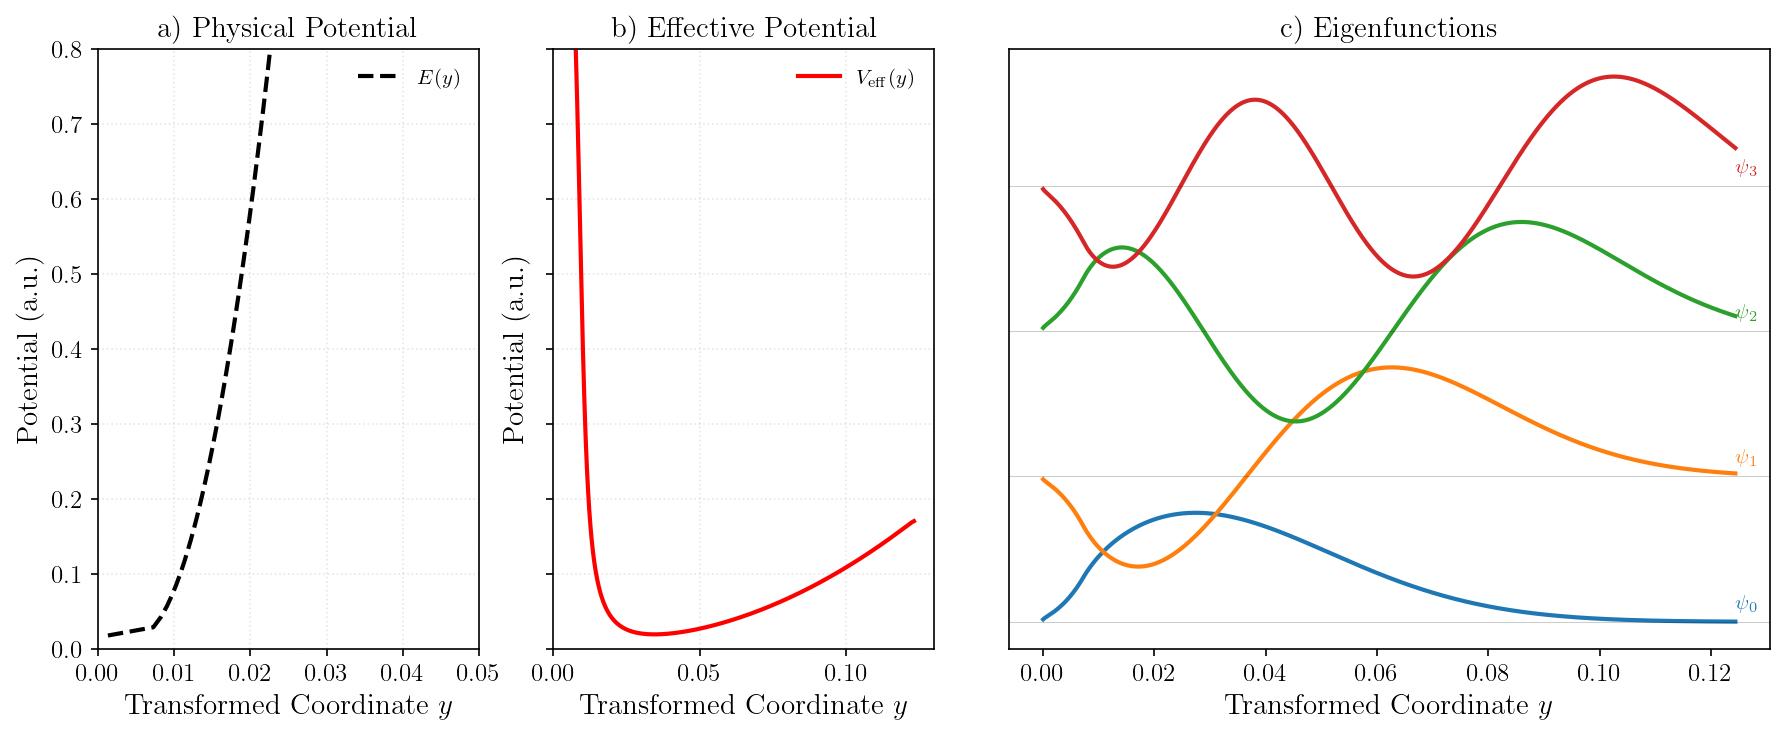

In [5]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# Figure: 1 x 3 grid, left two share old Figure-1 space
# -----------------------------------------------------------------------------
fig, (ax_phys, ax_eff, ax2) = plt.subplots(
    1, 3,
    figsize=(12, 5),
    gridspec_kw={'width_ratios': [1, 1, 2]}
)

# -----------------------------------------------------------------------------
# Effective Potential
# -----------------------------------------------------------------------------
W_sa = super_pot
dW_sa_dy = np.gradient(W_sa, hy, edge_order=2)
V_eff_raw = W_sa**2 + np.sqrt(Deff) * dW_sa_dy
V_eff_sa = gaussian_filter1d(V_eff_raw, sigma=35)

# -----------------------------------------------------------------------------
# Physical Potential
# -----------------------------------------------------------------------------
mask_core = (y > y[50]) & (y < y[-50])
shift_val = np.min(V_eff_sa[mask_core]) - np.min(E_of_y[mask_core])
E_shifted = E_of_y + shift_val

plot_mask = (y > y[30]) & (y < y[-30])

# -----------------------------------------------------------------------------
# Panel a1: Physical Potential
# -----------------------------------------------------------------------------
ax_phys.plot(
    y[plot_mask], E_shifted[plot_mask],
    'k--', lw=2, label=r'$E(y)$'
)

ax_phys.set_title("a) Physical Potential")
ax_phys.set_ylabel("Potential (a.u.)")
ax_phys.set_xlim(0, 0.05)
ax_phys.set_ylim(0, 0.8)
ax_phys.grid(True, linestyle=':', alpha=0.3)
ax_phys.set_xlabel(r"Transformed Coordinate $y$")
ax_phys.legend(frameon=False)

# -----------------------------------------------------------------------------
# Panel a2: Effective Potential
# -----------------------------------------------------------------------------
ax_eff.plot(
    y[plot_mask], V_eff_sa[plot_mask],
    'r-', lw=2, label=r'$V_{\mathrm{eff}}(y)$'
)

ax_eff.set_title("b) Effective Potential")
ax_eff.set_ylabel("Potential (a.u.)")
ax_eff.set_xlim(0, 0.13)
ax_eff.set_ylim(0, 0.8)
ax_eff.set_xlabel(r"Transformed Coordinate $y$")
ax_eff.grid(True, linestyle=':', alpha=0.3)
ax_eff.legend(frameon=False)

# Optional: clean look
ax_eff.set_yticklabels([])

# -----------------------------------------------------------------------------
# Panel b: Eigenfunctions (unchanged)
# -----------------------------------------------------------------------------
colors = [f'C{k}' for k in range(10)]

for k in range(4):
    offset = k * 0.8
    psi = psi_full[:, k]
    psi_plot = psi / np.max(np.abs(psi)) * 0.6

    if np.max(psi_plot) < abs(np.min(psi_plot)):
        psi_plot = -psi_plot

    ax2.plot(y, psi_plot + offset, lw=2, color=colors[k])
    ax2.axhline(offset, color='k', lw=0.5, alpha=0.2)
    ax2.text(y[-1], offset + 0.1, rf"$\psi_{k}$",
             color=colors[k], va='center')

ax2.set_title("c) Eigenfunctions")
ax2.set_xlabel(r"Transformed Coordinate $y$")
ax2.set_yticks([])

plt.tight_layout()
savefig_pdf("Figure_2")
plt.show()

--- Generating Convergence and Decay Plots ---


Computing Convergence (Reference: MC at t=10.00)...
Saved: figures/Figure_3.pdf


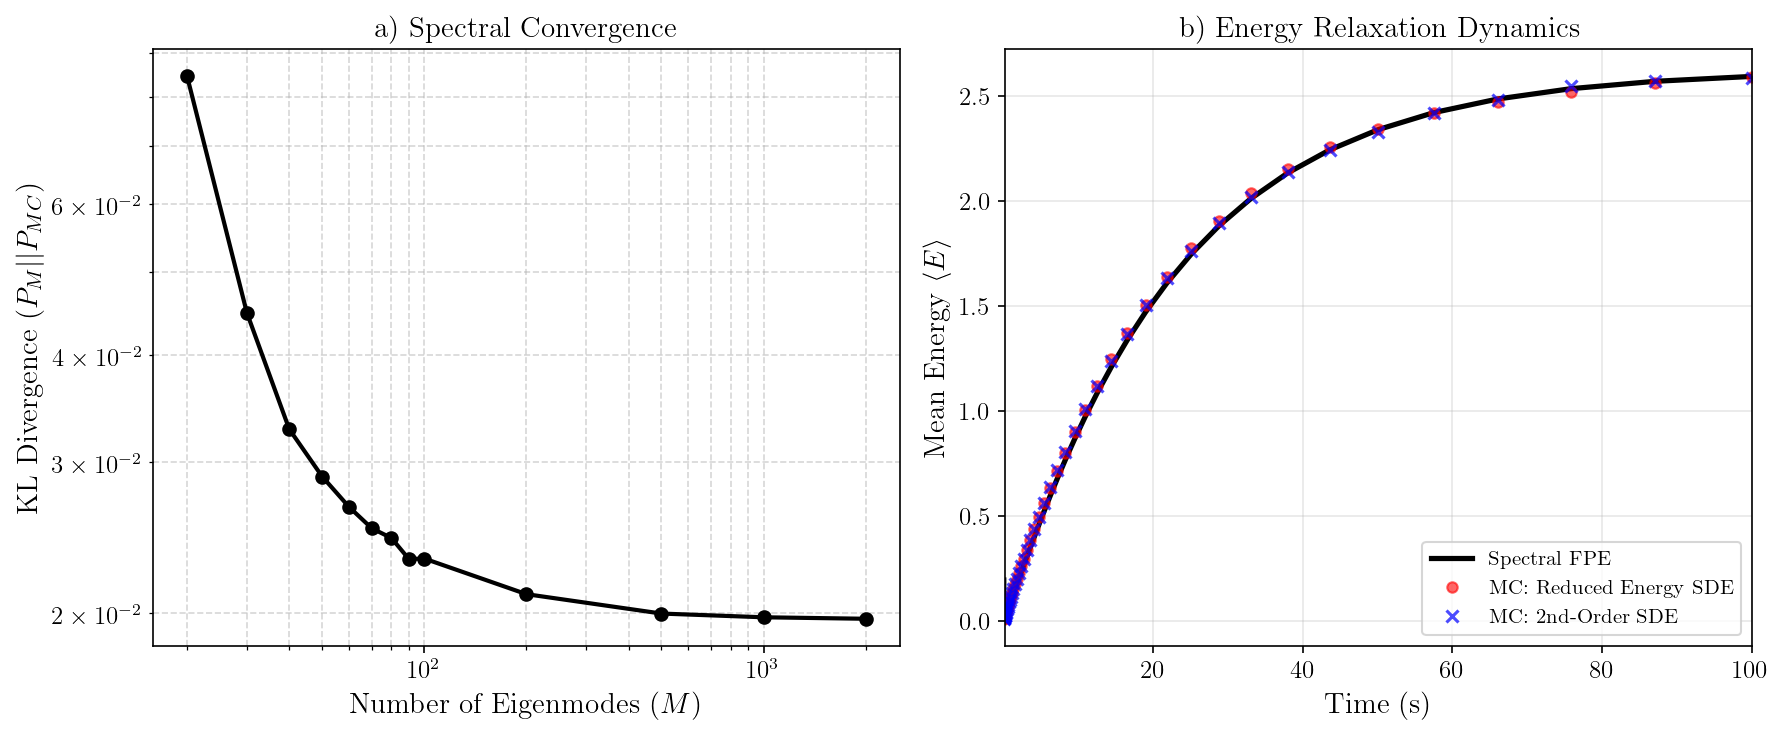

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# =============================================================================
# PLOT SET 2: Convergence Rate & Metastable Decay
# =============================================================================
print("--- Generating Convergence and Decay Plots ---")

# --- 1. Define Grid Convergence Helper ---
def solve_spectral_for_N(N, t_eval, pE0_global):
    # A. Grid Setup (Coarse y-grid)
    # We use the global metric defined in Section 8 (y_native, E_grid)
    y_N = np.linspace(y_min, y_max, N)
    hy_N = y_N[1] - y_N[0]
    
    # Map back to Energy
    E_N = np.interp(y_N, y_native, E_grid)
    
    # B. Interpolate Terms to New Grid
    # We rely on the global D1_grid, D2_grid, dD2_dE_grid
    D2_N = np.interp(E_N, E_grid, D2_grid)
    D1_N = np.interp(E_N, E_grid, D1_grid)
    dD2_N = np.interp(E_N, E_grid, dD2_dE_grid)
    
    # Jacobian terms (dy/dE = integrand)
    dy_dE_N = np.interp(E_N, E_grid, integrand)
    dE_dy_N = 1.0 / dy_dE_N

    # C. Construct Operator
    D1p_N = np.sqrt(Deff / np.maximum(D2_N, 1e-300)) * (D1_N - 0.5 * dD2_N)
    fprime_N = -D1p_N
    
    # Integrate f_N
    f_N = np.zeros_like(fprime_N)
    f_N[1:] = np.cumsum(0.5 * (fprime_N[1:] + fprime_N[:-1]) * hy_N)
    
    super_pot_N = fprime_N / (2.0 * np.sqrt(Deff))
    diff_factor_N = np.sqrt(Deff) / hy_N
    
    A_N = np.zeros((N, N))
    idx = np.arange(N - 1)
    A_N[idx, idx]   = super_pot_N[idx] - diff_factor_N
    A_N[idx, idx+1] = diff_factor_N
    A_N[-1, -1] = super_pot_N[-1] + diff_factor_N
    A_N[-1, -2] = -diff_factor_N
    
    H_N = A_N.T @ A_N
    
    # D. Solve Eigenproblem (Use all N modes)
    vals_N, vecs_N = np.linalg.eigh(H_N)
    
    # Normalize eigenvectors on y_N
    for k in range(N):
        norm = np.sqrt(np.trapezoid(vecs_N[:, k]**2, y_N))
        vecs_N[:, k] /= max(norm, 1e-300)
        
    # E. Project Initial Condition
    # Transform global pE0 to psi0_N
    pE0_N = np.interp(E_N, E_grid, pE0_global)
    # P(y) = P(E) * dE/dy
    Py0_N = pE0_N * dE_dy_N
    # psi(y) = P(y) * exp(f/2D)
    psi0_N = Py0_N * np.exp(f_N / (2.0 * Deff))
    
    coeffs_N = np.array([np.trapezoid(psi0_N * vecs_N[:, k], y_N) for k in range(N)])
    
    # F. Evolve to t_eval
    t_rel = t_eval - t_init
    psi_t_N = (vecs_N * (coeffs_N * np.exp(-vals_N * t_rel))[None, :]).sum(axis=1)
    
    # G. Reconstruct and Interpolate
    Py_t_N = psi_t_N * np.exp(-f_N / (2.0 * Deff))
    PE_t_N = Py_t_N * dy_dE_N # Convert back to P(E) density
    PE_t_N = np.maximum(PE_t_N, 0.0)
    
    # Interpolate to global E_grid for KL computation
    P_est = np.interp(E_grid, E_N, PE_t_N, left=0, right=0)
    norm = np.trapezoid(P_est, E_grid)
    return P_est / max(norm, 1e-300)

# --- 2. Setup Figure ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Panel A: Grid Discretization Convergence ---
check_time = 10
grid_sizes = [20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500, 1000, 2000]
kl_errors_grid = []

# A. Get MC Ground Truth at check_time
closest_t = min(snapshots_E_full.keys(), key=lambda k: abs(k - check_time))
samples_mc = snapshots_E_full[closest_t]
samples_mc = samples_mc[np.isfinite(samples_mc)]

# KDE for Ground Truth
kde_mc = gaussian_kde(samples_mc, bw_method=0.005) # or same bw as before
P_mc_truth = kde_mc(E_grid)
P_mc_truth /= np.trapezoid(P_mc_truth, E_grid)

# B. Compute KL for each Grid Size
print(f"Computing Convergence (Reference: MC at t={check_time:.2f})...")
for N in grid_sizes:
    P_N = solve_spectral_for_N(N, check_time, pE0)
    
    # KL Divergence
    p = np.maximum(P_N, 1e-16)
    q = np.maximum(P_mc_truth, 1e-16)
    kl = np.trapezoid(p * np.log(p / q), E_grid)
    kl_errors_grid.append(max(kl, 1e-16))

# C. Plot
ax1.loglog(grid_sizes, kl_errors_grid, 'o-', color='black', lw=2)
ax1.set_xlabel(r"Number of Eigenmodes ($M$)")
ax1.set_ylabel(r"KL Divergence ($P_M || P_{MC}$)")
ax1.set_title(r"a) Spectral Convergence")
ax1.grid(True, which="both", ls="--", alpha=0.5)
#ax1.legend()

# --- Panel B: Mean Energy Decay (Preserved from original) ---
E_mean_spec = []
E_mean_mc   = []   # Energy SDE (Reduced)
E_mean_full = []   # Kramers SDE (Full 2nd Order)

valid_times = [t for t in sorted(list(set(snapshot_times))) if t >= t_init]

for t in valid_times:
    # 1. Spectral Mean (from high-res global evo_spec)
    p_s = evo_spec[t]
    E_mean_s = np.trapezoid(E_grid * p_s, E_grid)
    E_mean_spec.append(E_mean_s)
    
    # 2. MC Mean (Reduced Energy SDE)
    s_mc = snapshots_E_sde.get(t)
    if s_mc is not None:
        s_mc = s_mc[np.isfinite(s_mc)]
        if len(s_mc) > 0:
            E_mean_mc.append(np.mean(s_mc))
        else:
            E_mean_mc.append(np.nan)
    else:
        E_mean_mc.append(np.nan)

    # 3. MC Mean (Full Kramers SDE)
    s_full = snapshots_E_full.get(t)
    if s_full is not None:
        s_full = s_full[np.isfinite(s_full)]
        if len(s_full) > 0:
            E_mean_full.append(np.mean(s_full))
        else:
            E_mean_full.append(np.nan)
    else:
        E_mean_full.append(np.nan)

ax2.plot(valid_times, E_mean_spec, 'k-', lw=2.5, label="Spectral FPE")
ax2.plot(valid_times, E_mean_mc, 'r.', ms=10, alpha=0.6, label="MC: Reduced Energy SDE ")
ax2.plot(valid_times, E_mean_full, 'bx', ms=6, markeredgewidth=1.5, alpha=0.7, label="MC: 2nd-Order SDE")

ax2.set_xlabel("Time (s)")
ax2.set_ylabel(r"Mean Energy $\langle E \rangle$")
ax2.set_title("b) Energy Relaxation Dynamics")
ax2.legend()
ax2.set_xlim([3e-1, 100])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
savefig_pdf("Figure_3")
plt.show()

# Adiabatic elimination - displacement

Potential: -0.50*13.00^2 + 0.33*6.50x^3 + 0.25*19.50x^4$
Damping ratio: 1.25
--- Computing Spectral Decomposition (Inertial Eq 18.19) ---
Spectral Solver (Inertial) Completed. Time: 1.8125 s
--- Computing Spectral Decomposition (Standard Smoluchowski) ---
Spectral Solver (Smol) Completed. Time: 0.7929 s
--- Found existing simulation data: data/mc_sim_-13.0_200000_4.0_9.npz ---
--- Generating Plots ---
Saved: figures/Figure_5.pdf


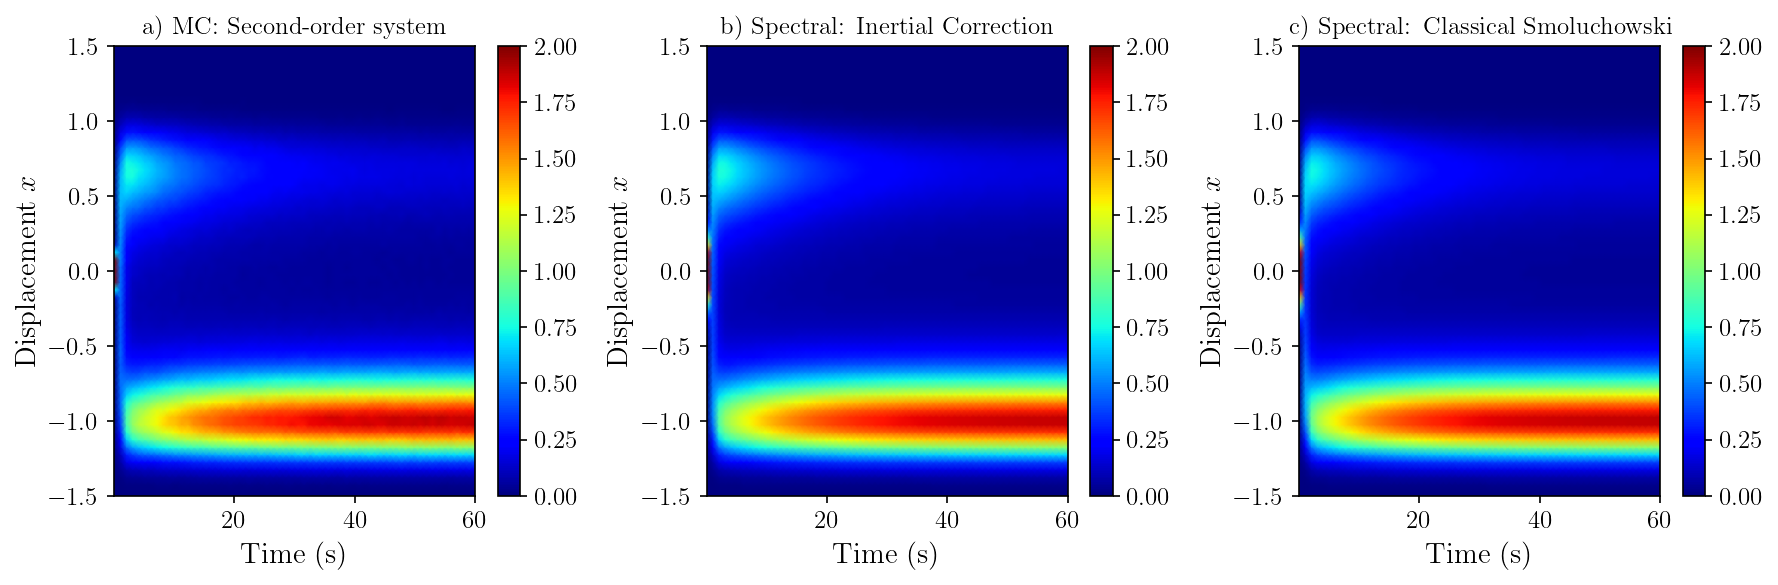

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import time
import os

import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 150,
    "savefig.bbox": "tight",
})

def savefig_pdf(fname):
    if not fname.lower().endswith(".pdf"):
        fname = 'figures/' + fname + ".pdf"
    plt.savefig(fname)
    print(f"Saved: {fname}")

# -------------------------------------------------------------------------
# 1. System Parameters
# -------------------------------------------------------------------------
omega0_sq = -13.0                     
eta       = 0.5*np.abs(omega0_sq)     
alpha     = 1.5*np.abs(omega0_sq)     

print(f'Potential: -0.50*{np.abs(omega0_sq):.2f}^2 + 0.33*{eta:.2f}x^3 + 0.25*{alpha:.2f}x^4$')

# Dynamics
beta      = 9     
zeta = beta/(2*np.sqrt(np.abs(omega0_sq)))
print(f'Damping ratio: {zeta:.2f}')
Dy_val    = 1.0      

# Physical Noise Intensity
D_phys = beta * Dy_val
D_eff = D_phys / (beta**2)

# Time Snapshots
t_start = 0.1
t_end   = 60.0
N_snapshots = 60
times = np.linspace(t_start, t_end, N_snapshots)

# --- GLOBAL DOMAIN DEFINITION ---
x_domain_min = -4.0
x_domain_max = 4.0

# Grid for Heatmap Interpolation
heatmap_ymin = -2.5
heatmap_ymax = 2.5
heatmap_ybins = 100
x_edges = np.linspace(heatmap_ymin, heatmap_ymax, heatmap_ybins + 1)
x_centers = 0.5 * (x_edges[1:] + x_edges[:-1])
dx_hist = x_edges[1] - x_edges[0]

# Storage
Z_spec      = np.zeros((heatmap_ybins, N_snapshots)) # Inertial Correction
Z_spec_smol = np.zeros((heatmap_ybins, N_snapshots)) # Standard Smoluchowski

# -------------------------------------------------------------------------
# 2. Physics & Derivatives
# -------------------------------------------------------------------------
def U(x): return 0.5*omega0_sq*x**2 + (1.0/3.0)*eta*x**3 + 0.25*alpha*x**4
def dUdx(x): return omega0_sq*x + eta*x**2 + alpha*x**3
def d2Udx2(x): return omega0_sq + 2*eta*x + 3*alpha*x**2
def d3Udx3(x): return 2*eta + 6*alpha*x

# -------------------------------------------------------------------------
# 3. Spectral Solver: Inertial Correction (Eq 18.19)
#    (Supersymmetric Factorization H = A.T @ A)
# -------------------------------------------------------------------------
print("--- Computing Spectral Decomposition (Inertial Eq 18.19) ---")
time_start_spec = time.time()

# A. Grid Setup
Nx_spec = 2200
x_grid = np.linspace(x_domain_min, x_domain_max, Nx_spec)

# Metric for Coordinate Transform
g_nat = 1.0 + d2Udx2(x_grid)/beta**2
J_x = 1.0 / np.sqrt(g_nat)

y_native = np.zeros_like(x_grid)
y_native[1:] = np.cumsum(0.5 * (J_x[1:] + J_x[:-1]) * (x_grid[1] - x_grid[0]))

# Uniform Y Grid
Ny = 3200 
y = np.linspace(y_native[0], y_native[-1], Ny)
hy = y[1] - y[0]
x_of_y = np.interp(y, y_native, x_grid)

# B. Effective Potential Terms
g_y = 1.0 + d2Udx2(x_of_y)/beta**2
D2_y = D_eff * g_y
dD2_y = D_eff * d3Udx3(x_of_y)/beta**2

# Drift Term W(y) (This is Phi'(y))
# D1_y is the physical drift, D1p_y is the drift in the flat metric
D1_y = -(dUdx(x_of_y)/beta)*g_y + dD2_y  
D1p_y = np.sqrt(D_eff / D2_y) * (D1_y - 0.5 * dD2_y)
W_y = -D1p_y # W_y corresponds to Phi'(y)

# C. Construct Annihilation Operator A
# Definition: a = sqrt(Deff)*d/dy + Phi'/(2*sqrt(Deff))
super_pot = W_y / (2.0 * np.sqrt(D_eff))
diff_factor = np.sqrt(D_eff) / hy

A_mat = np.zeros((Ny, Ny))

# Interior: Forward Difference (i=0 to N-2)
# a*v_i = diff_factor*(v_{i+1} - v_i) + super_pot_i * v_i
idx = np.arange(Ny - 1)
A_mat[idx, idx]   = super_pot[idx] - diff_factor
A_mat[idx, idx+1] = diff_factor

# Boundary: Backward Difference (i=N-1)
# a*v_{N-1} = diff_factor*(v_{N-1} - v_{N-2}) + super_pot_{N-1} * v_{N-1}
A_mat[-1, -1] = super_pot[-1] + diff_factor
A_mat[-1, -2] = -diff_factor

# D. Construct Hamiltonian H = A.T @ A
H_mat = A_mat.T @ A_mat

vals, vecs = eigh(H_mat)
vals, vecs = vals[np.argsort(vals)], vecs[:, np.argsort(vals)]
vals = vals - vals[0] 

# E. Reconstruction
# Reconstruct scaling factor from W_y (Phi')
f_y = np.zeros_like(W_y)
f_y[1:] = np.cumsum(0.5*(W_y[1:] + W_y[:-1])*hy)
f_y -= np.max(f_y)
scaling = np.exp(f_y/(2.0*D_eff))

p0_x = np.exp(-0.5*((x_of_y - 0.0)/0.01)**2)
p0_x /= np.trapezoid(p0_x, x_of_y)
dx_dy = np.sqrt(g_y)

p0_y = p0_x * dx_dy
psi0 = p0_y * scaling

modes = 600
c = np.array([np.trapezoid(psi0 * vecs[:,k], y) for k in range(modes)])

for i, t in enumerate(times):
    psi_t = (vecs[:, :modes] * (c * np.exp(-vals[:modes] * t))[None,:]).sum(axis=1)
    P_y_t = psi_t / scaling
    P_x_t = P_y_t / dx_dy
    P_x_t = np.maximum(P_x_t, 0)
    
    # Mass-Conserving Interpolation
    dx_native = np.diff(x_of_y)
    P_mid = 0.5 * (P_x_t[1:] + P_x_t[:-1])
    cdf_native = np.concatenate(([0], np.cumsum(P_mid * dx_native)))
    if cdf_native[-1] > 0: cdf_native /= cdf_native[-1]
    
    cdf_interp = np.interp(x_edges, x_of_y, cdf_native, left=0.0, right=1.0)
    Z_spec[:, i] = np.diff(cdf_interp) / dx_hist

time_elapsed_spec = time.time() - time_start_spec
print(f"Spectral Solver (Inertial) Completed. Time: {time_elapsed_spec:.4f} s")

# -------------------------------------------------------------------------
# 3.5. Spectral Solver: Standard Smoluchowski
# -------------------------------------------------------------------------
print("--- Computing Spectral Decomposition (Standard Smoluchowski) ---")
time_start_smol_spec = time.time()

# A. Grid Setup 
Nx_smol = 2200
x_smol = np.linspace(x_domain_min, x_domain_max, Nx_smol)
hx_smol = x_smol[1] - x_smol[0]

# B. Drift/Potential Terms
drift_smol = -dUdx(x_smol)/beta 
# Note: In Smoluchowski, Phi' = -Drift (if D is constant and normalized)
# Here Drift = F/beta. So Phi' = -F/beta.
Phi_prime_smol = -drift_smol 

# C. Construct Annihilation Operator A
super_pot_smol = Phi_prime_smol / (2.0 * np.sqrt(D_eff))
diff_factor_smol = np.sqrt(D_eff) / hx_smol

A_smol = np.zeros((Nx_smol, Nx_smol))

# Interior: Forward Difference
idx = np.arange(Nx_smol - 1)
A_smol[idx, idx]   = super_pot_smol[idx] - diff_factor_smol
A_smol[idx, idx+1] = diff_factor_smol

# Boundary: Backward Difference
A_smol[-1, -1] = super_pot_smol[-1] + diff_factor_smol
A_smol[-1, -2] = -diff_factor_smol

# D. Construct Hamiltonian H = A.T @ A
H_smol = A_smol.T @ A_smol

vals_smol, vecs_smol = eigh(H_smol)
vals_smol, vecs_smol = vals_smol[np.argsort(vals_smol)], vecs_smol[:, np.argsort(vals_smol)]
vals_smol = vals_smol - vals_smol[0]

# E. Reconstruction
scaling_arg_smol = -U(x_smol)/(2 * beta * D_eff)
scaling_arg_smol -= np.max(scaling_arg_smol)
scaling_inv_smol = np.exp(scaling_arg_smol) 

# Initial Condition P0(x)
p0_smol = np.exp(-0.5*((x_smol - 0.0)/0.01)**2)
p0_smol /= np.trapezoid(p0_smol, x_smol)

psi0_smol = p0_smol / scaling_inv_smol

c_smol = np.array([np.trapezoid(psi0_smol * vecs_smol[:,k], x_smol) for k in range(modes)])

for i, t in enumerate(times):
    psi_t = (vecs_smol[:, :modes] * (c_smol * np.exp(-vals_smol[:modes] * t))[None,:]).sum(axis=1)
    
    P_t_smol = psi_t * scaling_inv_smol
    P_t_smol = np.maximum(P_t_smol, 0)
    
    # Mass-Conserving Interpolation
    dx_local = hx_smol
    P_mid = 0.5 * (P_t_smol[1:] + P_t_smol[:-1])
    cdf_native = np.concatenate(([0], np.cumsum(P_mid * dx_local)))
    if cdf_native[-1] > 0: cdf_native /= cdf_native[-1]
    
    cdf_interp = np.interp(x_edges, x_smol, cdf_native, left=0.0, right=1.0)
    Z_spec_smol[:, i] = np.diff(cdf_interp) / dx_hist

time_elapsed_smol_spec = time.time() - time_start_smol_spec
print(f"Spectral Solver (Smol) Completed. Time: {time_elapsed_smol_spec:.4f} s")

# -------------------------------------------------------------------------
# 4. Monte Carlo Simulations (Reflecting BCs)
# -------------------------------------------------------------------------
M_paths = 200000 
dt = 1e-3
mc_filename = f"data/mc_sim_{omega0_sq}_{M_paths}_{x_domain_max}_{beta}.npz"

Z_full = np.zeros((heatmap_ybins, N_snapshots))
Z_red  = np.zeros((heatmap_ybins, N_snapshots))
Z_smol = np.zeros((heatmap_ybins, N_snapshots))
t_full, t_red, t_smol = 0.0, 0.0, 0.0

if os.path.exists(mc_filename):
    print(f"--- Found existing simulation data: {mc_filename} ---")
    data = np.load(mc_filename)
    Z_full, Z_red, Z_smol = data['Z_full'], data['Z_red'], data['Z_smol']
    t_full = data['t_full'].item()
    t_red = data['t_red'].item()
    t_smol = data['t_smol'].item()
else:
    print("--- Running Monte Carlo Simulations (Separately) ---")
    snap_map = {}
    for i, t in enumerate(times):
        step_num = int(round(t/dt))
        if step_num not in snap_map: snap_map[step_num] = i
    Nsteps = int(max(times)/dt)
    rng = np.random.default_rng(42)
    sqrt_2Deff = np.sqrt(2*D_eff)
    sqrt_dt = np.sqrt(dt)
    noise_full_amp = np.sqrt(2*D_phys*dt)

    def apply_reflection(x, v, x_max):
        mask_upper = x > x_max
        if np.any(mask_upper):
            x[mask_upper] = 2*x_max - x[mask_upper]
            if v is not None: v[mask_upper] *= -1
        mask_lower = x < -x_max
        if np.any(mask_lower):
            x[mask_lower] = -2*x_max - x[mask_lower]
            if v is not None: v[mask_lower] *= -1
        return x, v

    # A. Full Langevin
    print("1. Running Full Langevin...")
    t0 = time.time()
    x_full = np.zeros(M_paths); v_full = np.zeros(M_paths)
    for n in range(1, Nsteps + 1):
        noise = rng.normal(size=M_paths)
        x_new = x_full + v_full*dt
        v_new = v_full + (-beta*v_full - dUdx(x_full))*dt + noise_full_amp*noise
        x_full, v_full = apply_reflection(x_new, v_new, x_domain_max)
        if n in snap_map:
            hist, _ = np.histogram(x_full, bins=x_edges, density=True)
            Z_full[:, snap_map[n]] = hist
    t_full = time.time() - t0

    # B. Inertial Correction
    print("2. Running Inertial Correction...")
    t0 = time.time()
    x_red = np.zeros(M_paths)
    for n in range(1, Nsteps + 1):
        noise = rng.normal(size=M_paths)
        g = 1.0 + d2Udx2(x_red)/beta**2
        drift = -(dUdx(x_red)/beta)*g + (D_eff/beta**2)*d3Udx3(x_red)
        diff  = np.sqrt(2*D_eff*g)
        x_red += drift*dt + diff*sqrt_dt*noise
        x_red, _ = apply_reflection(x_red, None, x_domain_max)
        if n in snap_map:
            hist, _ = np.histogram(x_red, bins=x_edges, density=True)
            Z_red[:, snap_map[n]] = hist
    t_red = time.time() - t0

    # C. Standard Smoluchowski
    x_smol_mc = np.zeros(M_paths) 
    
    for n in range(1, Nsteps + 1):
        noise = rng.normal(size=M_paths)
        
        drift = -(dUdx(x_smol_mc)/beta)
        x_smol_mc += drift*dt + sqrt_2Deff*sqrt_dt*noise
        x_smol_mc, _ = apply_reflection(x_smol_mc, None, x_domain_max)
        
        if n in snap_map:
            hist, _ = np.histogram(x_smol_mc, bins=x_edges, density=True)
            Z_smol[:, snap_map[n]] = hist
            
    t_smol = time.time() - t0

    print(f"Saving data to {mc_filename}...")
    np.savez(mc_filename, Z_full=Z_full, t_full=t_full, Z_red=Z_red, t_red=t_red, Z_smol=Z_smol, t_smol=t_smol)

# -------------------------------------------------------------------------
# 5. Plotting
# -------------------------------------------------------------------------
print("--- Generating Plots ---")

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=False)
axes = axes.flatten()

plots_info = [
    ("a) MC: Second-order system", Z_full, t_full),
    ("b) Spectral: Inertial Correction", Z_spec, time_elapsed_spec),
    ("c) Spectral: Classical Smoluchowski", Z_spec_smol, time_elapsed_smol_spec),
]
vmax_val = np.max([Z_full.max(), Z_smol.max(), Z_red.max(), Z_spec.max()])

for i in range(3):
    ax = axes[i]
    title, data, elapsed = plots_info[i]
    pcm = ax.pcolormesh(times, x_centers, data, shading='gouraud', cmap='jet', vmin=0, vmax=2)
    ax.set_title(f"{title}", fontsize=12)
    ax.set_xlabel("Time (s)"); ax.set_ylabel("Displacement $x$")
    ax.set_ylim([-1.5, 1.5])
    fig.colorbar(pcm, ax=ax)

plt.tight_layout()
savefig_pdf("Figure_5")
plt.show()

--- Generating 2x4 Snapshot Grid ---
Plotting snapshots at times: [0.1        1.11525424 2.13050847 3.14576271 5.17627119 6.19152542
 7.20677966 9.23728814]
Saved: figures/Figure_4.pdf


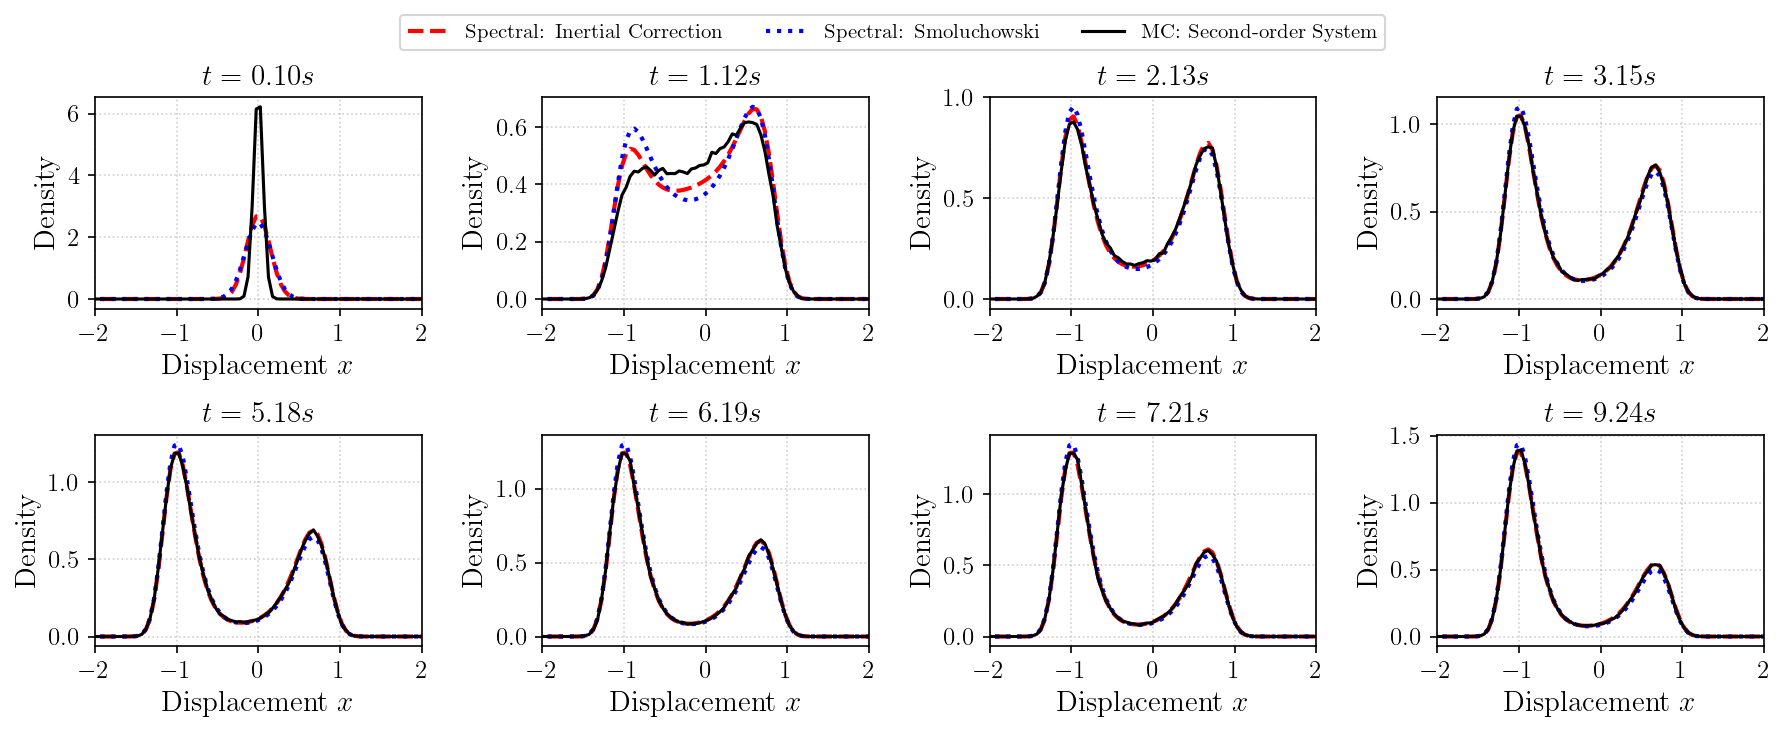

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------------------------
# 6. Grid Snapshot Plot (2x4)
# -------------------------------------------------------------------------
print("--- Generating 2x4 Snapshot Grid ---")

# Filter for indices where time is strictly less than 10.0 (matching your filter)
valid_indices = np.where(times <= 10.0)[0]
last_idx = valid_indices[-1]
indices_to_plot = np.linspace(0, last_idx, 8, dtype=int)

print(f"Plotting snapshots at times: {times[indices_to_plot]}")

# 2. Setup Figure
fig, axes = plt.subplots(2, 4, figsize=(12, 5), sharex=False, sharey=False)
axes = axes.flatten()

# 3. Define Styles
styles = {
    "MC: Second-order System":          {"c": "black",  "ls": "-",  "lw": 1.5, "alpha": 1,   "label": "MC: Second-order System"},
    #"MC: Inertial Correction":       {"c": "red",    "ls": "--", "lw": 1.5, "alpha": 1,   "label": "MC: Inertial Correction"},
    #"MC: Smoluchowski":              {"c": "blue",   "ls": ":",  "lw": 1.5, "alpha": 1,   "label": "MC: Smoluchowski"},
    "Spectral: Inertial Correction": {"c": "red",  "ls": "--",  "lw": 2.0, "alpha": 1.0, "label": "Spectral: Inertial Correction"},
    "Spectral: Smoluchowski":        {"c": "blue", "ls": ":",  "lw": 2.0, "alpha": 1.0, "label": "Spectral: Smoluchowski"}
}

for i, idx in enumerate(indices_to_plot):
    ax = axes[i]
    t_curr = times[idx]
    
    # Plot Spectral Data
    ax.plot(x_centers, Z_spec[:, idx],      **styles["Spectral: Inertial Correction"])
    ax.plot(x_centers, Z_spec_smol[:, idx], **styles["Spectral: Smoluchowski"])
    
    # Plot MC Data
    ax.plot(x_centers, Z_full[:, idx],      **styles["MC: Second-order System"])
    #ax.plot(x_centers, Z_red[:, idx],       **styles["MC: Inertial Correction"])
    #ax.plot(x_centers, Z_smol[:, idx],      **styles["MC: Smoluchowski"])
    
    # Formatting
    ax.set_title(f"$t = {t_curr:.2f}s$")
    ax.set_xlim(-2, 2)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.set_xlabel('Displacement $x$')
    ax.set_ylabel('Density')

# -------------------------------------------------------------------------
# GLOBAL LEGEND SETUP
# -------------------------------------------------------------------------
# 1. Get handles and labels from the last active axis (axes[-1])
handles, labels = axes[0].get_legend_handles_labels()

# 2. Create the figure-level legend
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), 
           ncol=5, fontsize=10, frameon=True)

# 3. Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.93])

savefig_pdf("Figure_4")
plt.show()

Saved: figures/Figure_6.pdf


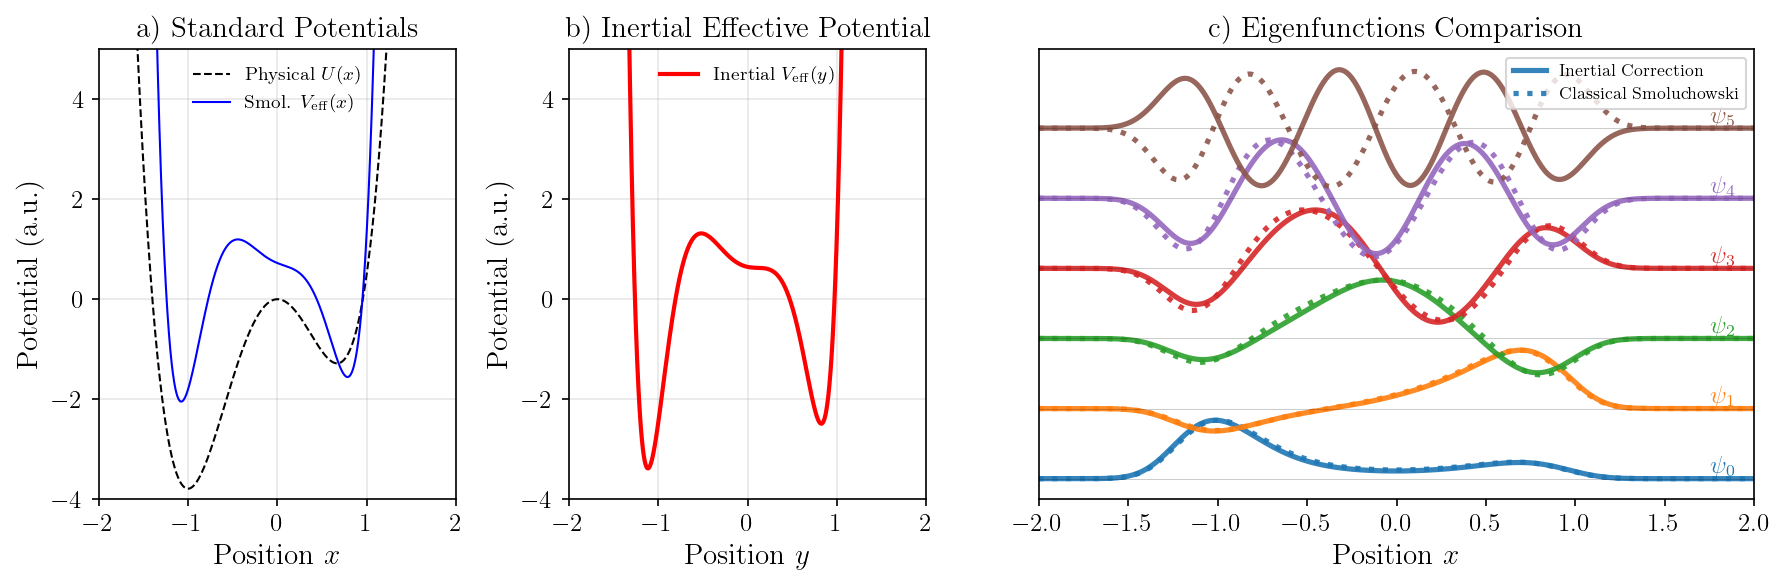

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Inertial Effective Potential V_eff(y)
g_y_plot = 1.0 + d2Udx2(x_of_y)/beta**2
dD2_y_plot = D_eff * d3Udx3(x_of_y)/beta**2

D1_y_plot = -(dUdx(x_of_y)/beta)*g_y_plot + dD2_y_plot
D1p_y_plot = np.sqrt(D_eff / (D_eff*g_y_plot)) * (D1_y_plot - 0.5 * dD2_y_plot)
W_y_plot = -D1p_y_plot 

hy_plot = y[1] - y[0]
term_W = W_y_plot / (2.0 * np.sqrt(D_eff))
dW_dy_plot = np.gradient(term_W, hy_plot, edge_order=2)
V_eff_in = (term_W**2) - (np.sqrt(D_eff) * dW_dy_plot)

# 2. Smoluchowski Effective Potential V_smol(x)
drift_smol_plot = -dUdx(x_smol)/beta
div_drift_plot  = -d2Udx2(x_smol)/beta
V_smol_raw = (drift_smol_plot**2)/(4*D_eff) + (0.5 * div_drift_plot)
V_eff_sm = np.interp(x_of_y, x_smol, V_smol_raw)

# 3. Physical Potential
U_vals = U(x_of_y)

# --- PLOTTING ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 3, 6]})

# ---------------------------------------------------------
# Panel 1: Physical U and Smoluchowski V_eff (Width: 3)
# ---------------------------------------------------------
ax1.plot(x_of_y, U_vals,   'k--', lw=1, alpha=1, label=r'Physical $U(x)$')
ax1.plot(x_of_y, V_eff_sm, 'b',   lw=1, alpha=1, label=r'Smol. $V_{\mathrm{eff}}(x)$')

ax1.set_xlabel(r"Position $x$")
ax1.set_ylabel("Potential (a.u.)")
ax1.set_title("a) Standard Potentials")
ax1.legend(loc='upper center', frameon=False, fontsize=9)
ax1.set_ylim(-4, 5)
ax1.set_xlim(-2.0, 2.0)
ax1.grid(True, alpha=0.3)

# ---------------------------------------------------------
# Panel 2: Inertial V_eff (Width: 3)
# ---------------------------------------------------------
ax2.plot(x_of_y, V_eff_in, 'r-', lw=2, label=r'Inertial $V_{\mathrm{eff}}(y)$')
#ax2.plot(x_of_y, U_vals, 'k--', lw=1, alpha=0.2) # Faint reference

ax2.set_xlabel(r"Position $y$")
ax2.set_ylabel("Potential (a.u.)")
ax2.set_title("b) Inertial Effective Potential")
ax2.legend(loc='upper center', frameon=False, fontsize=9)
ax2.set_ylim(-4, 5)
ax2.set_xlim(-2.0, 2.0)
ax2.grid(True, alpha=0.3)

# ---------------------------------------------------------
# Panel 3: Eigenmodes (Width: 6)
# ---------------------------------------------------------
colors = [f'C{k}' for k in range(10)]

for k in range(6):
    offset = k * 0.6
    col = colors[k] 
    
    # Inertial Mode 
    psi_in = vecs[:, k]
    psi_in = psi_in / np.max(np.abs(psi_in)) * 0.5
    
    # Smol Mode 
    psi_sm = vecs_smol[:, k]
    psi_sm = psi_sm / np.max(np.abs(psi_sm)) * 0.5
    psi_sm_interp = np.interp(x_of_y, x_smol, psi_sm) 
    
    # Plot 
    label_in = "Inertial Correction" if k==0 else None
    label_sm = "Classical Smoluchowski" if k==0 else None
    
    ax3.plot(x_of_y, psi_in + offset, color=col, ls='-', lw=2.5, alpha=0.9, label=label_in)
    ax3.plot(x_of_y, psi_sm_interp + offset, color=col, ls=':', lw=2.5, alpha=0.9, label=label_sm)
    ax3.axhline(offset, color='k', lw=0.5, alpha=0.2)
    ax3.text(1.75, offset + 0.1, rf"$\psi_{k}$", fontsize=12, color=col, va='center')

ax3.set_title("c) Eigenfunctions Comparison")
ax3.set_xlabel(r"Position $x$")
ax3.set_yticks([])
ax3.set_xlim([-2, 2])
ax3.legend(loc='upper right', fontsize=8, frameon=True)

plt.tight_layout()
savefig_pdf("Figure_6")
plt.show()

--- Computing Theoretical Kramers Rates ---
Correction Factor (Inertial/Smol): 0.8767
Relaxation Rate (Smol): 0.0904
Relaxation Rate (Inertial): 0.0792
Saved: figures/Figure_7.pdf


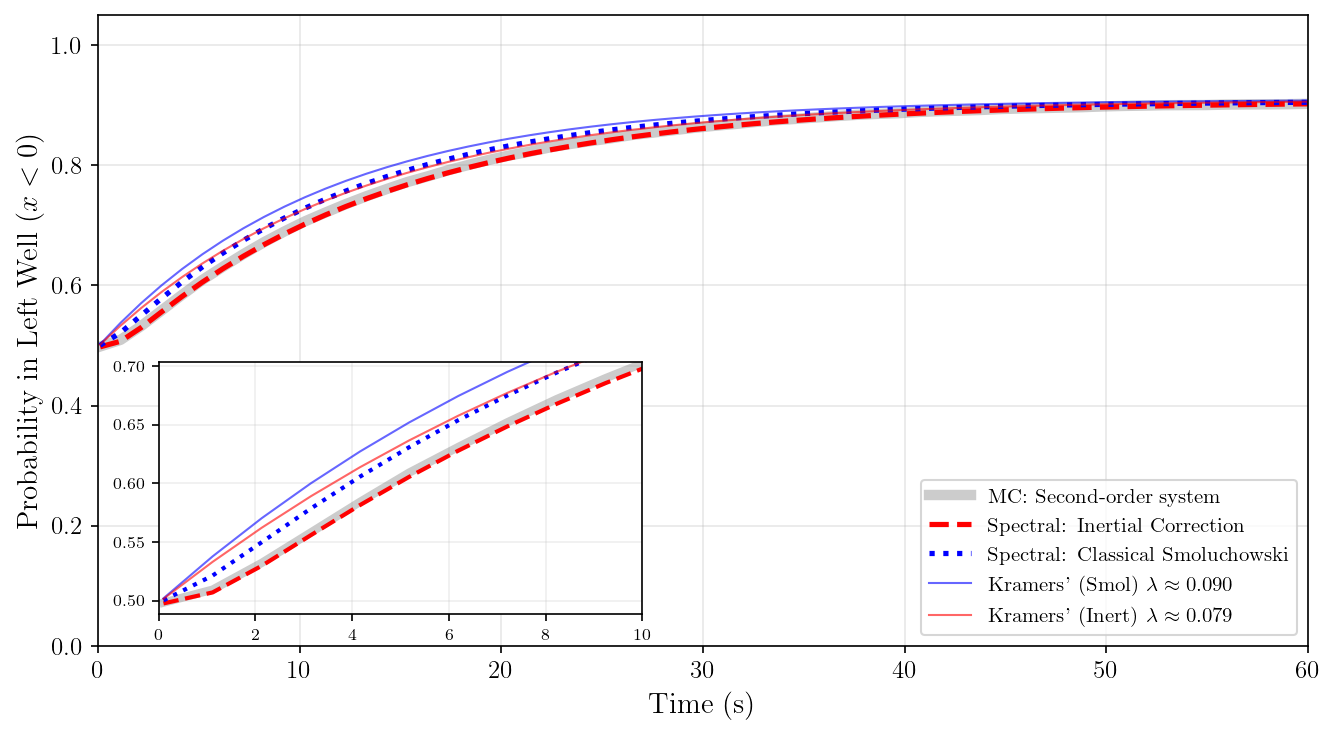

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# 5. Theoretical Kramers' Rate Analysis & Plotting
# =============================================================================

print("--- Computing Theoretical Kramers Rates ---")

# --- 1. Physics Calculations for Kramers Rate ---
# A. Find Stationary Points (Roots of U'(x))
roots_poly = np.roots([alpha, eta, omega0_sq])
points = np.sort(np.append(roots_poly, 0.0))

x_L = points[0]  # Left Well (Global Min)
x_B = points[1]  # Barrier (x=0)
x_R = points[2]  # Right Well (Local Min)

# B. Curvatures (omega^2 = |U''|)
w2_L = d2Udx2(x_L)
w2_B = np.abs(d2Udx2(x_B))
w2_R = d2Udx2(x_R)
w_L, w_B, w_R = np.sqrt(w2_L), np.sqrt(w2_B), np.sqrt(w2_R)

# C. Barrier Heights
kT_val = beta * D_eff

DeltaU_L = U(x_B) - U(x_L)
DeltaU_R = U(x_B) - U(x_R)

# D. Kramers Rates (Standard Smoluchowski Limit)
prefactor_smol_L = (w_L * w_B) / (2 * np.pi * beta)
prefactor_smol_R = (w_R * w_B) / (2 * np.pi * beta)

k_LR_smol = prefactor_smol_L * np.exp(-DeltaU_L / kT_val)
k_RL_smol = prefactor_smol_R * np.exp(-DeltaU_R / kT_val)

print(k_LR_smol, k_RL_smol)

lambda_smol = k_LR_smol + k_RL_smol
P_L_eq_theory = k_RL_smol / lambda_smol 

# E. Kramers Rates (Inertial / Kramers Turnover Correction)
mu_B = np.sqrt(beta**2/4.0 + w2_B) - beta/2.0
correction_factor = (mu_B * beta) / w2_B 

lambda_inert = lambda_smol * correction_factor

print(f"Correction Factor (Inertial/Smol): {correction_factor:.4f}")
print(f"Relaxation Rate (Smol): {lambda_smol:.4f}")
print(f"Relaxation Rate (Inertial): {lambda_inert:.4f}")

# =============================================================================
# PLOT SET 4: Convergence & Metastable Decay (Refined for Manuscript)
# =============================================================================
fig, ax2 = plt.subplots(1, 1, figsize=(9, 5))

# --- Panel B: Metastable Decay ---
# 1. Define Mask for Integration 
x_barrier = 0.0
left_mask_hist = x_centers < x_barrier 

# 2. Extract Data from Simulations
P_left_mc_full = []
P_left_sp_inert = []
P_left_sp_smol = []

for i in range(len(times)):
    P_left_mc_full.append(np.sum(Z_full[left_mask_hist, i]) * dx_hist)
    P_left_sp_inert.append(np.sum(Z_spec[left_mask_hist, i]) * dx_hist)
    P_left_sp_smol.append(np.sum(Z_spec_smol[left_mask_hist, i]) * dx_hist)

# 3. Generate Theoretical Curves
P_start = P_left_mc_full[0] 
theory_smol = P_L_eq_theory + (P_start - P_L_eq_theory) * np.exp(-lambda_smol * times)
theory_inert = P_L_eq_theory + (P_start - P_L_eq_theory) * np.exp(-lambda_inert * times)

# 4. Plot Main Simulation Data
ax2.plot(times, P_left_mc_full, color='gray', ls='-', lw=5, alpha=0.4, label="MC: Second-order system")
ax2.plot(times, P_left_sp_inert, 'r--', lw=2.5, label="Spectral: Inertial Correction")
ax2.plot(times, P_left_sp_smol, 'b:', lw=2.5, label="Spectral: Classical Smoluchowski")

# 5. Plot Analytical Rates
ax2.plot(times, theory_smol, 'b-', lw=1, alpha=0.6, label=fr"Kramers' (Smol) $\lambda \approx {lambda_smol:.3f}$")
ax2.plot(times, theory_inert, 'r-', lw=1, alpha=0.6, label=fr"Kramers' (Inert) $\lambda \approx {lambda_inert:.3f}$")

ax2.set_xlabel("Time (s)")
ax2.set_ylabel(r"Probability in Left Well ($x < 0$)")
ax2.legend(fontsize=10, loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 60)
ax2.set_ylim(0, 1.05)

# --- INSERT ZOOM-IN WINDOW ---
axins = ax2.inset_axes([0.05, 0.05, 0.4, 0.4]) 

# Plot the same data on the inset
axins.plot(times, P_left_mc_full, color='gray', ls='-', lw=4, alpha=0.4)
axins.plot(times, P_left_sp_inert, 'r--', lw=2)
axins.plot(times, P_left_sp_smol, 'b:', lw=2)
axins.plot(times, theory_smol, 'b-', lw=1, alpha=0.6)
axins.plot(times, theory_inert, 'r-', lw=1, alpha=0.6)

# Set Zoom Limits (0 to 10s)
x1, x2 = 0, 10
# Auto-find y limits for this range to make it look nice
y_data_slice = [p for t, p in zip(times, P_left_mc_full) if x1 <= t <= x2]
y1, y2 = min(y_data_slice)*0.98, max(y_data_slice)*1.02
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Optional: Add grid and tick formatting for the inset
axins.grid(True, alpha=0.2)
axins.tick_params(labelsize=8)

plt.tight_layout()
savefig_pdf("Figure_7")
plt.show()

Computing Test Solutions...
Saved: figures/Figure_8.pdf


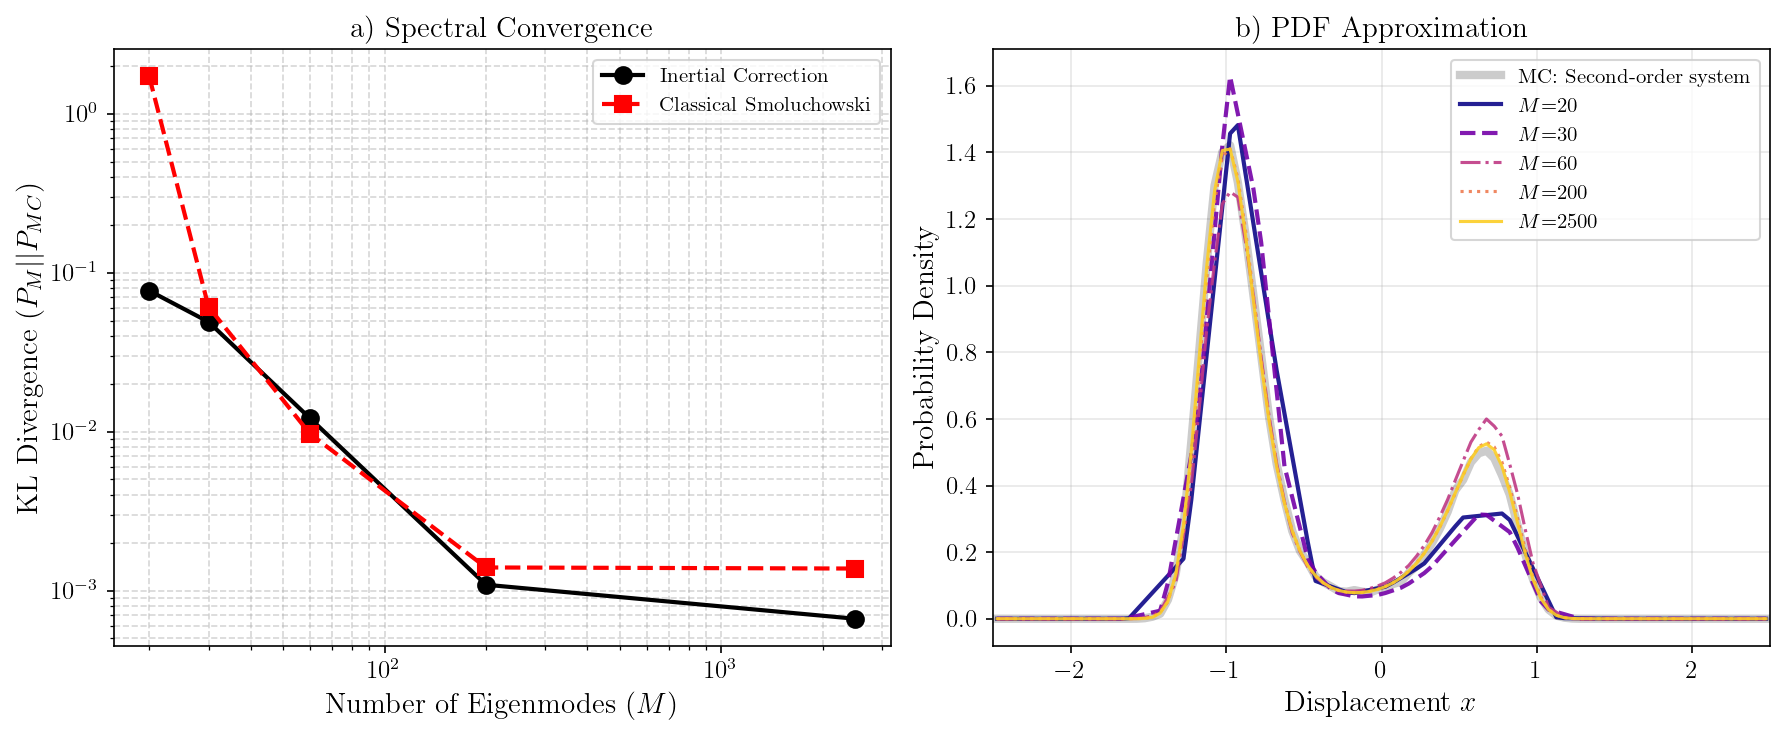

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import matplotlib.cm as cm

# =============================================================================
# DISCRETIZATION CONVERGENCE ANALYSIS
# =============================================================================

# 1. Configuration
target_time = 10.0
ref_grid_size = 2500
test_grid_sizes = [20, 30, 60, 200, 2500]
x_common = x_centers

# Identify index for MC Ground Truth at t=10
idx_t10 = np.abs(times - target_time).argmin()
P_mc_ground_truth = Z_full[:, idx_t10]

# --- ADAPTED STANDARD SMOLUCHOWSKI METHOD ---
def get_spectral_solution_at_t_smol(Ny_points, t_eval):
    # A. Grid Setup 
    Nx_smol = Ny_points
    x_smol = np.linspace(x_domain_min, x_domain_max, Nx_smol)
    hx_smol = x_smol[1] - x_smol[0]

    # B. Drift/Potential Terms
    drift_smol = -dUdx(x_smol)/beta 
    Phi_prime_smol = -drift_smol 

    # C. Construct Annihilation Operator A
    super_pot_smol = Phi_prime_smol / (2.0 * np.sqrt(D_eff))
    diff_factor_smol = np.sqrt(D_eff) / hx_smol

    A_smol = np.zeros((Nx_smol, Nx_smol))

    # Interior: Forward Difference
    idx = np.arange(Nx_smol - 1)
    A_smol[idx, idx]   = super_pot_smol[idx] - diff_factor_smol
    A_smol[idx, idx+1] = diff_factor_smol

    # Boundary: Backward Difference
    A_smol[-1, -1] = super_pot_smol[-1] + diff_factor_smol
    A_smol[-1, -2] = -diff_factor_smol

    # D. Construct Hamiltonian H = A.T @ A
    H_smol = A_smol.T @ A_smol

    # E. Solve Eigenproblem
    n_modes_calc = min(Nx_smol, 100)
    vals_smol, vecs_smol = eigh(H_smol)
    vals_smol = vals_smol - vals_smol[0]

    # F. Reconstruction
    scaling_arg_smol = -U(x_smol)/(2 * beta * D_eff)
    scaling_arg_smol -= np.max(scaling_arg_smol)
    scaling_inv_smol = np.exp(scaling_arg_smol) 

    # Initial Condition P0(x)
    p0_smol = np.exp(-0.5*((x_smol - 0.0)/0.01)**2)
    p0_smol /= np.trapezoid(p0_smol, x_smol)

    psi0_smol = p0_smol / scaling_inv_smol

    c_smol = np.array([np.trapezoid(psi0_smol * vecs_smol[:,k], x_smol) for k in range(n_modes_calc)])

    # Time Evolution
    psi_t = (vecs_smol[:, :n_modes_calc] * (c_smol * np.exp(-vals_smol[:n_modes_calc] * t_eval))[None,:]).sum(axis=1)
    
    P_t_smol = psi_t * scaling_inv_smol
    P_t_smol = np.maximum(P_t_smol, 0)
    
    # Interpolate to Common Grid
    P_common_smol = np.interp(x_common, x_smol, P_t_smol, left=0, right=0)
    norm_final = np.trapezoid(P_common_smol, x_common)

    return P_common_smol / max(norm_final, 1e-300)

# 2. Helper Function: Solve Spectral Problem (Inertial Correction)
def get_spectral_solution_at_t(Ny_points, t_eval):
    # A. Grid Setup (Approximate x_domain range)
    x_fine = np.linspace(x_domain_min, x_domain_max, 10000) 
    
    # Recalculate Metric/Transformation
    g_nat = 1.0 + d2Udx2(x_fine)/beta**2
    J_x = 1.0 / np.sqrt(g_nat)
    y_native_fine = np.zeros_like(x_fine)
    y_native_fine[1:] = np.cumsum(0.5 * (J_x[1:] + J_x[:-1]) * (x_fine[1] - x_fine[0]))
    
    # Define Uniform Y grid
    y_min, y_max = y_native_fine[0], y_native_fine[-1]
    y = np.linspace(y_min, y_max, Ny_points)
    hy = y[1] - y[0]
    
    # Map back to x
    x_of_y = np.interp(y, y_native_fine, x_fine)
    
    # B. Effective Potential & Drift
    g_y = 1.0 + d2Udx2(x_of_y)/beta**2
    D2_y = D_eff * g_y
    dD2_y = D_eff * d3Udx3(x_of_y)/beta**2
    
    D1_y = -(dUdx(x_of_y)/beta)*g_y + dD2_y  
    D1p_y = np.sqrt(D_eff / D2_y) * (D1_y - 0.5 * dD2_y)
    W_y = -D1p_y 

    # C. Build Hamiltonian
    super_pot = W_y / (2.0 * np.sqrt(D_eff))
    diff_factor = np.sqrt(D_eff) / hy
    
    A_mat = np.zeros((Ny_points, Ny_points))
    idx = np.arange(Ny_points - 1)
    A_mat[idx, idx]   = super_pot[idx] - diff_factor
    A_mat[idx, idx+1] = diff_factor
    A_mat[-1, -1] = super_pot[-1] + diff_factor
    A_mat[-1, -2] = -diff_factor
    
    H_mat = A_mat.T @ A_mat
    
    # D. Solve Eigenproblem
    n_modes_calc = min(Ny_points - 2, 100) 
    vals, vecs = eigh(H_mat, subset_by_index=[0, n_modes_calc-1])
    vals = vals - vals[0]
    
    # E. Reconstruct PDF
    f_y = np.zeros_like(W_y)
    f_y[1:] = np.cumsum(0.5*(W_y[1:] + W_y[:-1])*hy)
    f_y -= np.max(f_y)
    scaling = np.exp(f_y/(2.0*D_eff))
    
    p0_x = np.exp(-0.5*((x_of_y - 0.0)/0.01)**2)
    dx_dy_local = np.sqrt(g_y)
    p0_y = p0_x * dx_dy_local
    p0_y /= np.trapezoid(p0_y, y)
    
    psi0 = p0_y * scaling
    c_coeffs = np.array([np.trapezoid(psi0 * vecs[:,k], y) for k in range(n_modes_calc)])
    
    psi_t = (vecs * (c_coeffs * np.exp(-vals * t_eval))[None,:]).sum(axis=1)
    P_y_t = psi_t / scaling
    P_x_t = P_y_t / dx_dy_local
    
    P_common = np.interp(x_common, x_of_y, P_x_t, left=0, right=0)
    norm_final = np.trapezoid(P_common, x_common)
    return P_common / max(norm_final, 1e-300)

# 3. Compute Solutions
kl_errors = []
kl_errors_smol = []
pdfs_stored = []
pdfs_stored_smol = []

print("Computing Test Solutions...")
for N in test_grid_sizes:
    # Inertial Correction (Original)
    P_N = get_spectral_solution_at_t(N, target_time)
    pdfs_stored.append(P_N)
    
    p = np.maximum(P_N, 1e-16)
    q = np.maximum(P_mc_ground_truth, 1e-16)
    kl = np.trapezoid(p * np.log(p / q), x_common)
    kl_errors.append(max(kl, 1e-16)) 

    # Classical Smoluchowski
    P_N_smol = get_spectral_solution_at_t_smol(N, target_time)
    pdfs_stored_smol.append(P_N_smol)
    
    p = np.maximum(P_N_smol, 1e-16)
    kl = np.trapezoid(p * np.log(p / q), x_common)
    kl_errors_smol.append(max(kl, 1e-16)) 

# =============================================================================
# PLOTTING
# =============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- LEFT PLOT: Discretization Convergence (KL) ---
ax1.loglog(test_grid_sizes, kl_errors, 'o-', color='black', lw=2, markersize=8, label='Inertial Correction')
ax1.loglog(test_grid_sizes, kl_errors_smol, 's--', color='red', lw=2, markersize=8, label='Classical Smoluchowski')
ax1.set_xlabel(r"Number of Eigenmodes ($M$)")
ax1.set_ylabel(r"KL Divergence ($P_M || P_{MC}$)")
ax1.set_title(r"a) Spectral Convergence") 
ax1.legend()
ax1.grid(True, which="both", ls="--", alpha=0.5)

# --- RIGHT PLOT: PDF Shapes vs Ground Truth ---
ax2.plot(x_common, P_mc_ground_truth, color='black', lw=4, alpha=0.2, label='MC: Second-order system')

line_styles = ['-', '--', '-.', ':']
colors = cm.plasma(np.linspace(0, 0.9, len(test_grid_sizes)))

for i, N in enumerate(test_grid_sizes):
    ls = line_styles[i % len(line_styles)]
    c = colors[i]
    lbl = f'$M$={N}'
    lw_val = 2.0 if N < 50 else 1.5
    
    ax2.plot(x_common, pdfs_stored[i], color=c, ls=ls, lw=lw_val, alpha=0.9, label=lbl)

ax2.set_xlim(-2.5, 2.5)
ax2.set_xlabel(r"Displacement $x$")
ax2.set_ylabel(r"Probability Density")
ax2.set_title(fr"b) PDF Approximation")
ax2.legend(loc='upper right', ncol=1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
savefig_pdf("Figure_8") 
plt.show()

# CN

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.sparse import diags
from scipy.sparse.linalg import splu
import os
import matplotlib as mpl

# -------------------------------------------------------------------------
# Plot settings
# -------------------------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 150,
    "savefig.bbox": "tight",
})

# -------------------------------------------------------------------------
# 1. System Parameters
# -------------------------------------------------------------------------
omega0_sq = -13.0
eta       = 0.5*np.abs(omega0_sq)
alpha     = 1.5*np.abs(omega0_sq)

beta      = 9.0
Dy_val    = 1.0

D_phys = beta * Dy_val
D_eff  = D_phys / beta**2

# We align the snapshots to integer seconds so the CN method with dt=1
# hits them exactly.
dt_stress_test = 1.0
t_start = dt_stress_test
t_end = 60.0
# Generate times: 1.0, 2.0, 3.0, ..., 60.0
times = np.arange(t_start, t_end + 0.1, dt_stress_test)
N_snapshots = len(times)

x_domain_min, x_domain_max = -4.0, 4.0

heatmap_ymin, heatmap_ymax = -2.5, 2.5
heatmap_ybins = 100
x_edges = np.linspace(heatmap_ymin, heatmap_ymax, heatmap_ybins + 1)
x_centers = 0.5*(x_edges[1:]+x_edges[:-1])
dx_hist = x_edges[1]-x_edges[0]

Z_spec = np.zeros((heatmap_ybins, N_snapshots))
Z_cn   = np.zeros_like(Z_spec)

# -------------------------------------------------------------------------
# 2. Potential
# -------------------------------------------------------------------------
def U(x):      return 0.5*omega0_sq*x**2 + eta*x**3/3 + alpha*x**4/4
def dUdx(x):   return omega0_sq*x + eta*x**2 + alpha*x**3
def d2Udx2(x): return omega0_sq + 2*eta*x + 3*alpha*x**2
def d3Udx3(x): return 2*eta + 6*alpha*x

# -------------------------------------------------------------------------
# 3. Spectral Solver
# -------------------------------------------------------------------------
print("Solving spectral")
Nx = 100
x_grid = np.linspace(x_domain_min, x_domain_max, Nx)

g_nat = 1.0 + d2Udx2(x_grid)/beta**2
J_x = 1.0/np.sqrt(g_nat)

y_native = np.zeros_like(x_grid)
y_native[1:] = np.cumsum(0.5*(J_x[1:]+J_x[:-1])*(x_grid[1]-x_grid[0]))

y = np.linspace(y_native[0], y_native[-1], Nx)
hy = y[1]-y[0]
x_of_y = np.interp(y, y_native, x_grid)

g_y = 1.0 + d2Udx2(x_of_y)/beta**2
D2_y = D_eff*g_y
dD2_y = D_eff*d3Udx3(x_of_y)/beta**2

D1_y = -(dUdx(x_of_y)/beta)*g_y + dD2_y
D1p_y = np.sqrt(D_eff/D2_y)*(D1_y - 0.5*dD2_y)
W_y = -D1p_y

super_pot = W_y/(2*np.sqrt(D_eff))
diff = np.sqrt(D_eff)/hy

A = np.zeros((Nx,Nx))
for i in range(Nx-1):
    A[i,i] = super_pot[i] - diff
    A[i,i+1] = diff
A[-1,-1] = super_pot[-1] + diff
A[-1,-2] = -diff

H = A.T@A
vals,vecs = eigh(H)
vals -= vals[0]

f_y = np.zeros_like(W_y)
f_y[1:] = np.cumsum(0.5*(W_y[1:]+W_y[:-1])*hy)
scaling = np.exp(f_y/(2*D_eff))

p0 = np.exp(-0.5*((x_of_y)/0.01)**2)
p0 /= np.trapezoid(p0,x_of_y)
dx_dy = np.sqrt(g_y)
psi0 = p0*dx_dy*scaling

modes = 100
c = np.array([np.trapezoid(psi0*vecs[:,k],y) for k in range(modes)])

for i,t in enumerate(times):
    psi_t = (vecs[:,:modes]*(c*np.exp(-vals[:modes]*t))).sum(axis=1)
    Px = psi_t/(scaling*dx_dy)
    Px = np.maximum(Px,0)

    dxn = np.diff(x_of_y)
    Pm = 0.5*(Px[1:]+Px[:-1])
    cdf = np.concatenate(([0],np.cumsum(Pm*dxn)))
    cdf /= cdf[-1]
    Z_spec[:,i] = np.diff(np.interp(x_edges,x_of_y,cdf))/dx_hist

# -------------------------------------------------------------------------
# 4. Crank–Nicolson Solver (Direct x-domain)
# -------------------------------------------------------------------------
print("Solving CN in x-domain")

Nx_cn = 300
x_cn = np.linspace(x_domain_min, x_domain_max, Nx_cn)
dx_cn = x_cn[1] - x_cn[0]

# Physics Arrays
g_x = 1.0 + (omega0_sq + 2*eta*x_cn + 3*alpha*x_cn**2)/beta**2
term1 = (-omega0_sq*x_cn - eta*x_cn**2 - alpha*x_cn**3)/beta * g_x
term2 = (D_phys/beta**4) * (2*eta + 6*alpha*x_cn)
A_x = term1 + term2
D_x = (D_phys/beta**2) * g_x

diff_term = D_x / dx_cn**2
adv_term  = A_x / (2*dx_cn)

lower = diff_term[:-1] + adv_term[:-1]
main  = -2 * diff_term
upper = diff_term[1:] - adv_term[1:]

L = diags([lower, main, upper], [-1, 0, 1], format="csc")

# Time Stepping Setup
dt_cn = 1# Set to 1.0 as requested
I = diags([np.ones(Nx_cn)], [0])
M_lhs = I - 0.5*dt_cn*L
M_rhs = I + 0.5*dt_cn*L
solver = splu(M_lhs)

# Initial Condition
P = np.exp(-0.5*((x_cn)/0.01)**2)
P /= np.trapezoid(P, x_cn)

current_t = 0.0
snap = 0

# Calculate exactly how many steps are needed to reach t_end
total_steps = int(round(t_end / dt_cn))

for step in range(total_steps + 1):
    # 1. Check if we need to save a snapshot
    # We check if the current time is close to the next scheduled snapshot
    if snap < N_snapshots and np.abs(current_t - times[snap]) < dt_cn * 0.5:
        Px = np.maximum(P, 0)
        mass_dist = 0.5*(Px[1:]+Px[:-1]) * np.diff(x_cn)
        cdf = np.concatenate(([0], np.cumsum(mass_dist)))
        if cdf[-1] > 0: cdf /= cdf[-1]
        
        Z_cn[:,snap] = np.diff(np.interp(x_edges, x_cn, cdf))/dx_hist
        snap += 1

    # 2. Crank-Nicolson Step
    P = solver.solve(M_rhs @ P)
    current_t += dt_cn

# -------------------------------------------------------------------------
# 5. Monte Carlo Simulations
# -------------------------------------------------------------------------
print("Solving MC")
M_paths = 200000
dt = 1e-3
mc_filename = f"data/mc_sim_{omega0_sq}_{M_paths}_{x_domain_max}_{beta}.npz"

Z_full = np.zeros((heatmap_ybins, N_snapshots))
Z_red  = np.zeros((heatmap_ybins, N_snapshots))
Z_smol = np.zeros((heatmap_ybins, N_snapshots))
t_full, t_red, t_smol = 0.0, 0.0, 0.0

if os.path.exists(mc_filename):
    data = np.load(mc_filename)
    print("simulation found!")
    Z_full, Z_red, Z_smol = data['Z_full'], data['Z_red'], data['Z_smol']
else:
    snap_map = {int(round(t/dt)):i for i,t in enumerate(times)}
    Nsteps = int(max(times)/dt)
    rng = np.random.default_rng(42)

    x_red = np.zeros(M_paths)

    for n in range(1, Nsteps+1):
        noise = rng.normal(size=M_paths)
        g = 1.0 + d2Udx2(x_red)/beta**2
        drift = -(dUdx(x_red)/beta)*g + (D_eff/beta**2)*d3Udx3(x_red)
        diff = np.sqrt(2*D_eff*g)
        x_red += drift*dt + diff*np.sqrt(dt)*noise
        x_red = np.clip(x_red, -x_domain_max, x_domain_max)

        if n in snap_map:
            Z_red[:,snap_map[n]],_ = np.histogram(x_red,bins=x_edges,density=True)
    
    np.savez(mc_filename, Z_full=Z_full, Z_red=Z_red, Z_smol=Z_smol)

Solving spectral
Solving CN in x-domain
Solving MC
simulation found!


/tmp/ipykernel_363727/4007051921.py:158: SparseEfficiencyWarning: splu converted its input to CSC format
  solver = splu(M_lhs)


In [9]:
Z_cn_aux = np.zeros_like(Z_spec)

# -------------------------------------------------------------------------
# 4. Crank–Nicolson Solver (Direct x-domain)
# -------------------------------------------------------------------------
print("Solving CN in x-domain")

Nx_cn = 300
x_cn = np.linspace(x_domain_min, x_domain_max, Nx_cn)
dx_cn = x_cn[1] - x_cn[0]

# Physics Arrays
g_x = 1.0 + (omega0_sq + 2*eta*x_cn + 3*alpha*x_cn**2)/beta**2
term1 = (-omega0_sq*x_cn - eta*x_cn**2 - alpha*x_cn**3)/beta * g_x
term2 = (D_phys/beta**4) * (2*eta + 6*alpha*x_cn)
A_x = term1 + term2
D_x = (D_phys/beta**2) * g_x

diff_term = D_x / dx_cn**2
adv_term  = A_x / (2*dx_cn)

lower = diff_term[:-1] + adv_term[:-1]
main  = -2 * diff_term
upper = diff_term[1:] - adv_term[1:]

L = diags([lower, main, upper], [-1, 0, 1], format="csc")

# Time Stepping Setup
dt_cn = 0.5# Set to 1.0 as requested
I = diags([np.ones(Nx_cn)], [0])
M_lhs = I - 0.5*dt_cn*L
M_rhs = I + 0.5*dt_cn*L
solver = splu(M_lhs)

# Initial Condition
P_aux = np.exp(-0.5*((x_cn)/0.01)**2)
P_aux /= np.trapezoid(P, x_cn)

current_t = 0.0
snap = 0

# Calculate exactly how many steps are needed to reach t_end
total_steps = int(round(t_end / dt_cn))

for step in range(total_steps + 1):
    # 1. Check if we need to save a snapshot
    # We check if the current time is close to the next scheduled snapshot
    if snap < N_snapshots and np.abs(current_t - times[snap]) < dt_cn * 0.5:
        Px = np.maximum(P_aux, 0)
        mass_dist = 0.5*(Px[1:]+Px[:-1]) * np.diff(x_cn)
        cdf = np.concatenate(([0], np.cumsum(mass_dist)))
        if cdf[-1] > 0: cdf /= cdf[-1]
        
        Z_cn_aux[:,snap] = np.diff(np.interp(x_edges, x_cn, cdf))/dx_hist
        snap += 1

    # 2. Crank-Nicolson Step
    P_aux = solver.solve(M_rhs @ P_aux)
    current_t += dt_cn

Solving CN in x-domain


/tmp/ipykernel_363727/3843649632.py:33: SparseEfficiencyWarning: splu converted its input to CSC format
  solver = splu(M_lhs)


Saved: figures/Figure_9.pdf


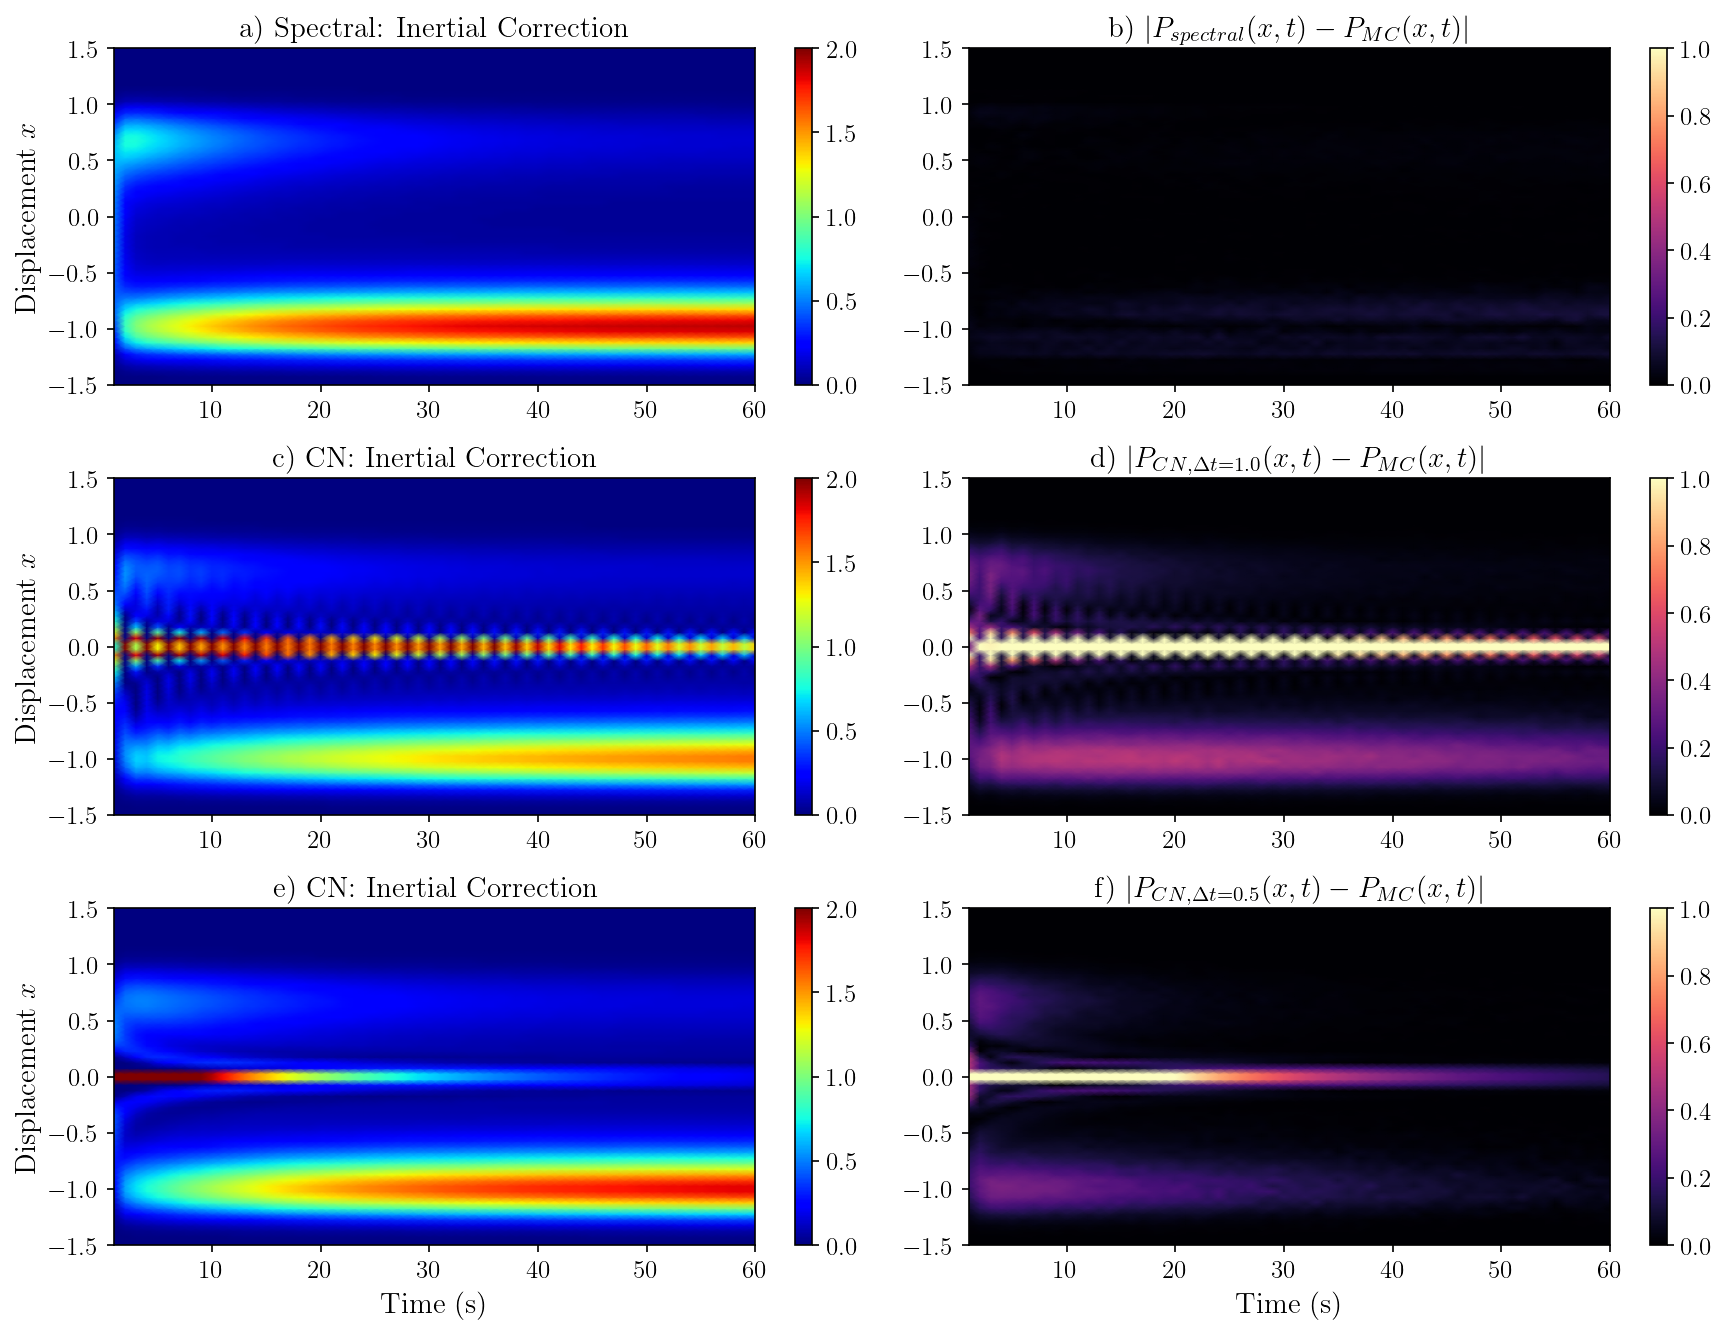

In [12]:
def savefig_pdf(fname):
    if not fname.lower().endswith(".pdf"):
        fname = 'figures/' + fname + ".pdf"
    plt.savefig(fname)
    print(f"Saved: {fname}")

import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 150,
    "savefig.bbox": "tight",
})

# -------------------------------------------------------------------------
# 6. Errors vs Monte Carlo
# -------------------------------------------------------------------------
Z_mc = Z_red.copy()
Err_spec = np.abs(Z_spec - Z_mc)
Err_cn   = np.abs(Z_cn - Z_mc)
Err_cn_aux   = np.abs(Z_cn_aux - Z_mc)

# -------------------------------------------------------------------------
# 7. 2x2 Plot
# -------------------------------------------------------------------------
fig, ax = plt.subplots(3,2, figsize=(12,9))

plots = [
    (Z_spec, "a) Spectral: Inertial Correction", "jet"),
    (Err_spec, r"b) $|P_{spectral}(x,t) - P_{MC}(x,t)|$", "magma"),
    (Z_cn, "c) CN: Inertial Correction", "jet"),
    (Err_cn, r"d) $|P_{CN,\Delta t=1.0}(x,t) - P_{MC}(x,t)|$", "magma"),
    (Z_cn_aux, "e) CN: Inertial Correction", "jet"),
    (Err_cn_aux, r"f) $|P_{CN,\Delta t=0.5}(x,t) - P_{MC}(x,t)|$", "magma")
]

for a,(Z,title,cmap) in zip(ax.flat,plots):
    pcm = a.pcolormesh(times,x_centers,Z,shading="gouraud",
                       cmap=cmap,
                       vmin=0 if "MC" in title else 0,
                       vmax=1 if "MC" in title else 2)
    a.set_title(title)
    a.set_ylim([-1.5,1.5])
    fig.colorbar(pcm, ax=a)

ax[2,0].set_xlabel("Time (s)")
ax[2,1].set_xlabel("Time (s)")
ax[0,0].set_ylabel("Displacement $x$")
ax[1,0].set_ylabel("Displacement $x$")
ax[2,0].set_ylabel("Displacement $x$")

plt.tight_layout()
savefig_pdf("Figure_9") 
plt.show()

# 2DOF example - Duffing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.sparse as sp
import time
import os, hashlib
import matplotlib as mpl

# -------------------------------------------------------------------------
# 0. Configuration
# -------------------------------------------------------------------------
if not os.path.exists('data'): os.makedirs('data')

def savefig_pdf(fname):
    if not fname.lower().endswith(".pdf"):
        fname = 'figures/' + fname + ".pdf"
    if not os.path.exists('figures'): os.makedirs('figures')
    plt.savefig(fname)
    print(f"Saved: {fname}")

# =============================================================================
# Matplotlib config (LaTeX style)
# =============================================================================
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 150,
    "savefig.bbox": "tight",
})

# --- Physics Parameters (From LaTeX) ---
m1, m2 = 1.0, 1.0
c_damp = 100.0       # c1 = c2 = 25
k1, k2 = 10.0, 10.0   # k1 = k2 = 10
kc     = 1        # kc = 1

# Nonlinear coefficients
beta1, beta2   = 10.0, 10.0
alpha1, alpha2 = 10.0, 10.0
delta2         = 1.0 

# Noise Intensity
# D_eff = D_val / c^2 for Smoluchowski
D_val = 4

# --- Simulation Settings ---
# High damping means system relaxes quickly. 
times = [0.1, 1.0, 2.0, 4.0, 8.0, 16] 
t_end = 16.1
dt_mc = 5e-4 # Smaller time step for stiff spring (k=10)

# Grid
L_phys = 0.26  # Domain size
N_grid = 191  # Grid resolution

# -------------------------------------------------------------------------
# 1. Physics Modules
# -------------------------------------------------------------------------
def get_potential(x1, x2):
    """
    Constructs the potential surface U(x1, x2).
    Integrals of the EOM:
    Row 1: (k1+kc)x1 - kc*x2 + beta1*x1^2 + alpha1*x1^3 - delta*(x2-x1)^3
    Row 2: -kc*x1 + (k2+kc)x2 + beta2*x2^2 + alpha2*x2^3 + delta*(x2-x1)^3
    """
    
    # 1. Local Potentials (from integration of local terms)
    # Integral(k x + beta x^2 + alpha x^3) -> 1/2 k x^2 + 1/3 beta x^3 + 1/4 alpha x^4
    U_local_1 = 0.5*k1*x1**2 + (1.0/3.0)*beta1*x1**3 + 0.25*alpha1*x1**4
    U_local_2 = 0.5*k2*x2**2 + (1.0/3.0)*beta2*x2**3 + 0.25*alpha2*x2**4
    
    # 2. Coupling Potential
    # Linear coupling: 1/2 kc (x2 - x1)^2
    # Nonlinear coupling: Integral of -delta*(x2-x1)^3 dx1 -> 1/4 delta (x2-x1)^4
    diff = x2 - x1
    U_coupling = 0.5*kc*(diff)**2 + 0.25*delta2*(diff)**4
    
    return U_local_1 + U_local_2 + U_coupling

def get_gradient_U(x1, x2):
    """
    Returns [dU/dx1, dU/dx2]. This is exactly the LHS of the EOM (excluding inertia/damping).
    """
    diff = x2 - x1 # (x2 - x1)
    diff_cubed = diff**3
    
    # Force 1 (Restoring force on x1)
    # (k1+kc)x1 - kc*x2 + beta1*x1^2 + alpha1*x1^3 - delta*(x2-x1)^3
    # Note: The term -delta*(x2-x1)^3 matches the LaTeX vector exactly.
    F_restoring_1 = (k1 + kc)*x1 - kc*x2 + beta1*x1**2 + alpha1*x1**3 - delta2*diff_cubed
    
    # Force 2 (Restoring force on x2)
    # -kc*x1 + (k2+kc)x2 + beta2*x2^2 + alpha2*x2^3 + delta*(x2-x1)^3
    F_restoring_2 = -kc*x1 + (k2 + kc)*x2 + beta2*x2**2 + alpha2*x2**3 + delta2*diff_cubed
    
    return np.array([F_restoring_1, F_restoring_2])

# -------------------------------------------------------------------------
# 2. Robust Spectral Solver (Supersymmetric / Smoluchowski)
# -------------------------------------------------------------------------
def run_spectral_solver_isotropic():
    print("\n" + "="*40)
    print("   SPECTRAL SOLVER (Smoluchowski Limit)")
    print("="*40)

    # 1. Grid Setup
    x = np.linspace(-L_phys, L_phys, N_grid)
    hx = x[1] - x[0]
    X1, X2 = np.meshgrid(x, x, indexing='ij')
    
    # 2. Physics Scaling (Overdamped Limit)
    # Effective diffusion in position space: D_eff = D_noise / c^2
    D_eff = D_val / (c_damp**2)
    
    # Scaled Potential: Phi = U / c
    U_grid = get_potential(X1, X2)
    Phi = U_grid / c_damp
    Phi -= np.min(Phi)
    
    # 3. Supersymmetric Hamiltonian Construction
    dPhi_dx1 = np.gradient(Phi, hx, axis=0).ravel()
    dPhi_dx2 = np.gradient(Phi, hx, axis=1).ravel()
    
    # W_k = (1 / 2*sqrt(D)) * dPhi/dx_k
    W1 = dPhi_dx1 / (2.0 * np.sqrt(D_eff))
    W2 = dPhi_dx2 / (2.0 * np.sqrt(D_eff))
    
    # Operators
    N = N_grid
    ones = np.ones(N)
    D_1D = sp.diags([-ones, ones], [0, 1], shape=(N, N)) / hx
    I = sp.eye(N)
    
    # A_x (Axis 0)
    D_x_2D = sp.kron(D_1D, I) 
    A_1 = np.sqrt(D_eff) * D_x_2D + sp.diags(W1)
    
    # A_y (Axis 1)
    D_y_2D = sp.kron(I, D_1D) 
    A_2 = np.sqrt(D_eff) * D_y_2D + sp.diags(W2)
    
    print("[Spec] Assembling Sparse Hamiltonian...")
    H_mat = A_1.T @ A_1 + A_2.T @ A_2
    
    print("[Spec] Solving Eigenproblem (Sparse)...")
    import scipy.sparse.linalg as spla
    vals, vecs = spla.eigsh(H_mat, k=N_grid, which='SM')
    
    print(f"[Spec] First 5 Eigenvalues: {vals[:5]}")
    
    # 4. Initial Condition (Gaussian centered at 0)
    sigma_ic = 4.0 * hx
    print(sigma_ic)
    R2 = X1**2 + X2**2
    P0 = np.exp(-R2 / (2*sigma_ic**2))
    P0 /= np.sum(P0) * hx**2
    
    # Transform P0 -> Psi0 (similarity transform)
    scaling_factor = np.exp(Phi / (2.0 * D_eff))
    Psi0 = P0 * scaling_factor
    
    coeffs = vecs.T @ (Psi0.ravel() * hx**2)
    
    # 5. Time Evolution
    Z_out = []
    inv_scaling = np.exp(-Phi / (2.0 * D_eff)) 
    
    for t in times:
        Psi_t_flat = vecs @ (coeffs * np.exp(-vals * t))
        Psi_t = Psi_t_flat.reshape(N_grid, N_grid)
        P_t = Psi_t * inv_scaling
        P_t = np.maximum(P_t, 0)
        norm = np.sum(P_t) * hx**2
        if norm > 1e-10: P_t /= norm
        Z_out.append(P_t)
        
    return Z_out

# -------------------------------------------------------------------------
# 3. Monte Carlo (Second-Order / Inertial)
# -------------------------------------------------------------------------
def run_mc_second_order():
    print("\n" + "="*40)
    print("   MONTE CARLO (Inertial)")
    print("="*40)
    
    M_paths = 200000 
    hx = (2 * L_phys) / (N_grid - 1)
    sigma_ic = 4.0 * hx 
    
    # Unique hash for these specific physics parameters
    h_str = f"{dt_mc}_{c_damp}_{k1}_{beta1}_{delta2}_{D_val}_{M_paths}_{t_end}"
    h = hashlib.md5(h_str.encode()).hexdigest()[:6]
    fname = f"data/mc_stiff_{h}.npz"
    bins = np.linspace(-L_phys, L_phys, N_grid)

    if os.path.exists(fname):
        print("Loading cached MC...")
        return np.load(fname)['dens']

    N_steps = int(t_end / dt_mc)
    
    # --- IC: Centered Gaussian ---
    x = np.random.normal(0.0, sigma_ic, (2, M_paths))
    v = np.zeros((2, M_paths))
    
    # Damping Matrix (Diagonal)
    C_vec = np.array([[c_damp], [c_damp]]) # Broadcastable
    
    # Noise Scale
    # SDE: m dv = (- c v - gradU) dt + B dW
    # Intensity of W is 2*D_val.
    noise_scale = np.sqrt(2 * D_val * dt_mc)
    
    dens = []
    save_steps = [int(t/dt_mc) for t in times]
    curr_idx = 0
    
    print(f"Simulating {N_steps} steps...")
    for n in range(N_steps+1):
        if curr_idx < len(save_steps) and n == save_steps[curr_idx]:
            H, _, _ = np.histogram2d(x[0], x[1], bins=[bins, bins], density=True)
            dens.append(H)
            curr_idx += 1
        
        # Gradient of U corresponds to 'Restoring Forces'
        gradU = get_gradient_U(x[0], x[1])
        
        # Euler-Maruyama for Langevin
        # dv = ( -gradU - C*v ) * dt + noise
        force_total = -gradU - (C_vec * v)
        
        v += force_total * dt_mc + np.random.randn(2, M_paths) * noise_scale
        x += v * dt_mc
        
        # Simple boundary check to prevent explosion if timestep is too large
        if np.max(np.abs(x)) > L_phys * 10:
            print("Warning: Particle explosion detected. Reduce dt_mc.")
            break
        
    np.savez(fname, dens=np.array(dens))
    return np.array(dens)

start = time.perf_counter()
Z_spec = run_spectral_solver_isotropic()
print(f"Spectral Time: {time.perf_counter()-start:.2f}s")

start = time.perf_counter()
Z_mc = run_mc_second_order()
print(f"MC Time: {time.perf_counter()-start:.2f}s")


   SPECTRAL SOLVER (Smoluchowski Limit)
[Spec] Assembling Sparse Hamiltonian...
[Spec] Solving Eigenproblem (Sparse)...
[Spec] First 5 Eigenvalues: [3.99653131e-06 9.94035991e-02 1.19665073e-01 1.98806406e-01
 2.19467413e-01]
0.010947368421052595
Spectral Time: 36.54s

   MONTE CARLO (Inertial)
Loading cached MC...
MC Time: 0.00s


Saved: figures/Figure_10.pdf


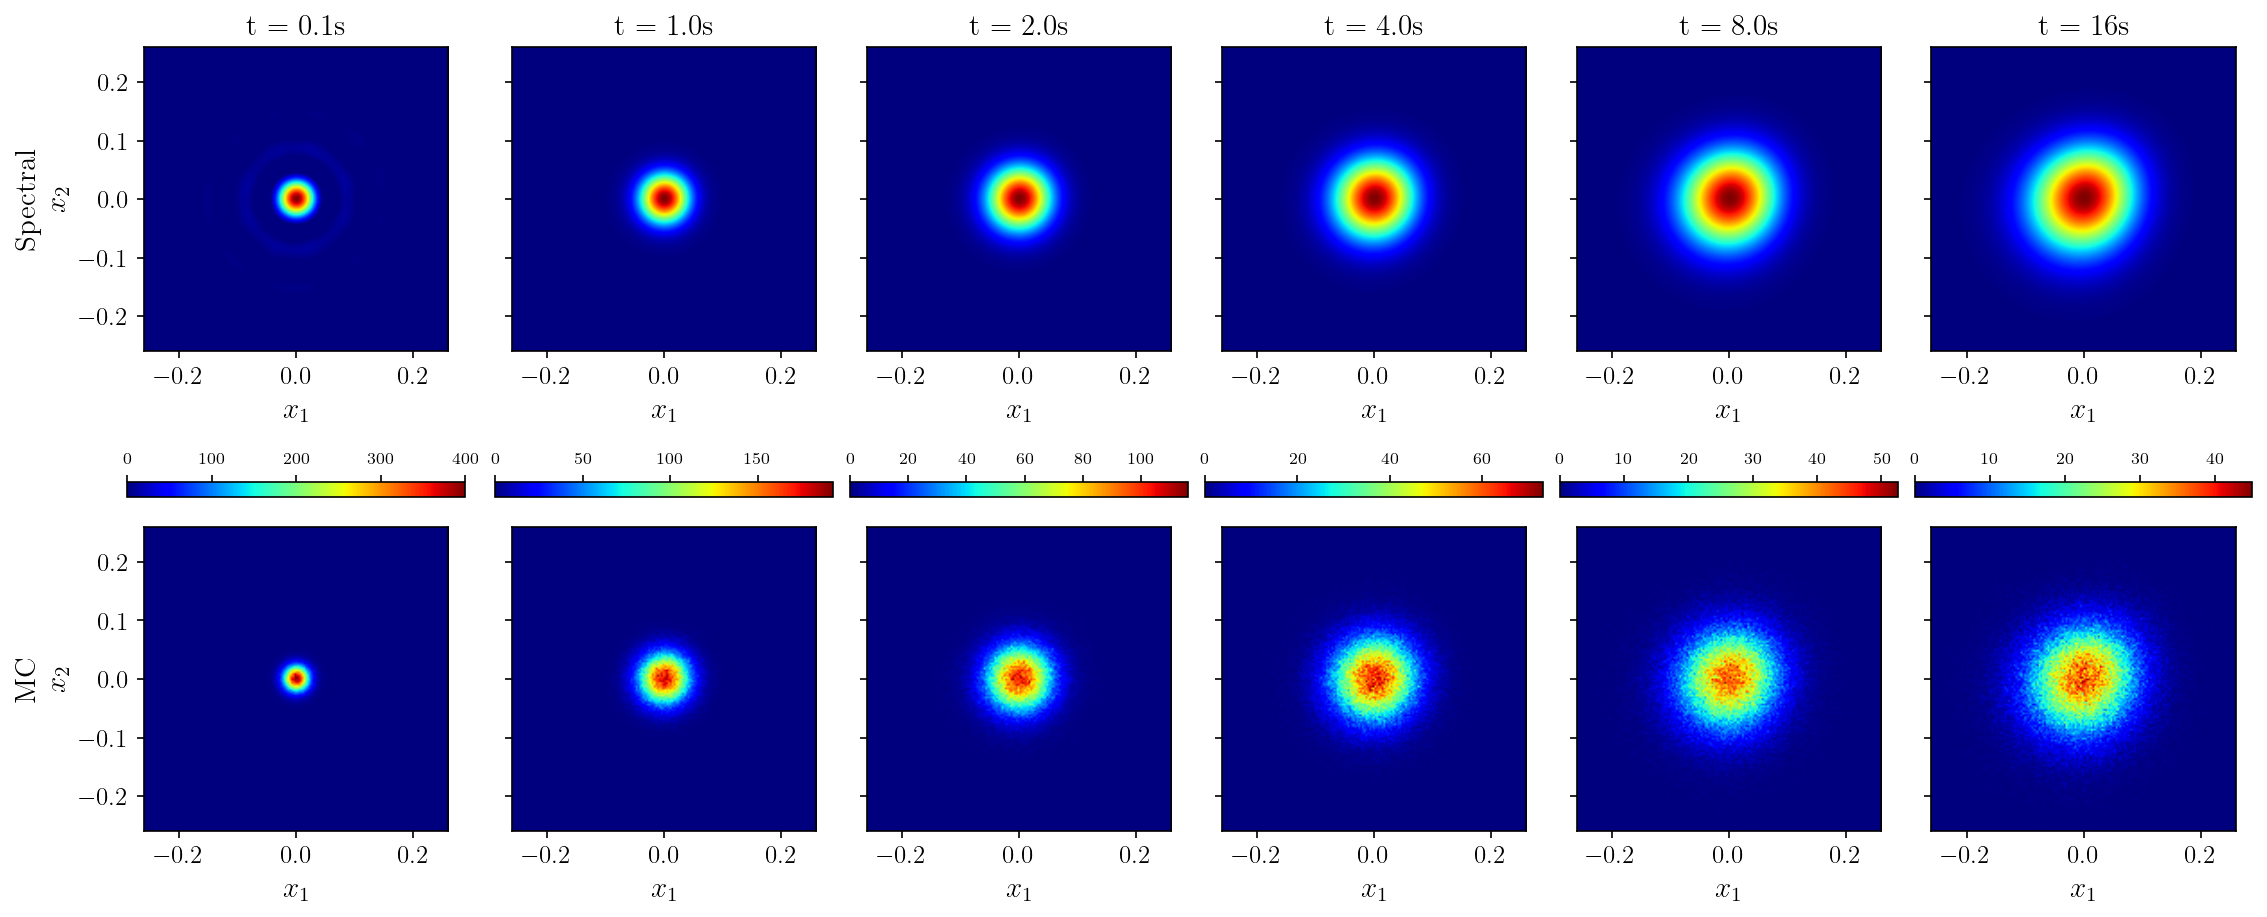

In [4]:
# -------------------------------------------------------------------------
# 4. Visualization (Horizontal Colorbar Between Rows)
# -------------------------------------------------------------------------
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(15, 6), constrained_layout=True)
gs = fig.add_gridspec(3, len(times), height_ratios=[1, 0.05, 1], hspace=0.1)

extent = [-L_phys, L_phys, -L_phys, L_phys]

for i in range(len(times)):
    # 1. Create Axes for this column
    ax_spec = fig.add_subplot(gs[0, i]) # Top
    ax_cbar = fig.add_subplot(gs[1, i]) # Middle (Colorbar)
    ax_mc   = fig.add_subplot(gs[2, i]) # Bottom

    # 3. Plot Spectral (Top)
    im = ax_spec.imshow(Z_spec[i].T, origin='lower', extent=extent, 
                        cmap='jet', vmin=0, interpolation='bilinear')
    ax_spec.set_title(f"t = {times[i]}s")
    ax_spec.set_xlabel('$x_1$')
    if i == 0: 
        ax_spec.set_ylabel('Spectral\n$x_2$')
    else:
        ax_spec.set_yticklabels([])

    # 4. Plot MC (Bottom)
    if i < len(Z_mc):
        ax_mc.imshow(Z_mc[i].T, origin='lower', extent=extent, 
                     cmap='jet', vmin=0, interpolation='bilinear')
    
    if i == 0: 
        ax_mc.set_ylabel('MC\n$x_2$')
    else:
        ax_mc.set_yticklabels([])
    ax_mc.set_xlabel('$x_1$')

    # 5. Add Horizontal Colorbar (Middle)
    cbar = plt.colorbar(im, cax=ax_cbar, orientation='horizontal')
    ax_cbar.xaxis.set_ticks_position('top') 
    ax_cbar.tick_params(labelsize=8)

savefig_pdf("Figure_10")
plt.show()

<>:165: SyntaxWarning: invalid escape sequence '\p'
<>:165: SyntaxWarning: invalid escape sequence '\l'
<>:175: SyntaxWarning: invalid escape sequence '\p'
<>:165: SyntaxWarning: invalid escape sequence '\p'
<>:165: SyntaxWarning: invalid escape sequence '\l'
<>:175: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_402977/4212772699.py:165: SyntaxWarning: invalid escape sequence '\p'
  ax[i].set_title(f"{letters[i]} $\psi_{i}$ ($\lambda={vals[i]:.4f}$)")
/tmp/ipykernel_402977/4212772699.py:165: SyntaxWarning: invalid escape sequence '\l'
  ax[i].set_title(f"{letters[i]} $\psi_{i}$ ($\lambda={vals[i]:.4f}$)")
/tmp/ipykernel_402977/4212772699.py:175: SyntaxWarning: invalid escape sequence '\p'
  cbar.set_label('Amplitude $\psi(x)$')



   SPECTRAL SOLVER (Eigenfunctions)
   Grid: 191x191, L=0.26
[Spec] Assembling Sparse Hamiltonian...
[Spec] Solving Eigenproblem (Sparse Shift-Invert)...
[Spec] First 4 Eigenvalues: [3.99653124e-06 9.94035991e-02 1.19665073e-01 1.98806406e-01]
Saved: figures/Figure_11.pdf


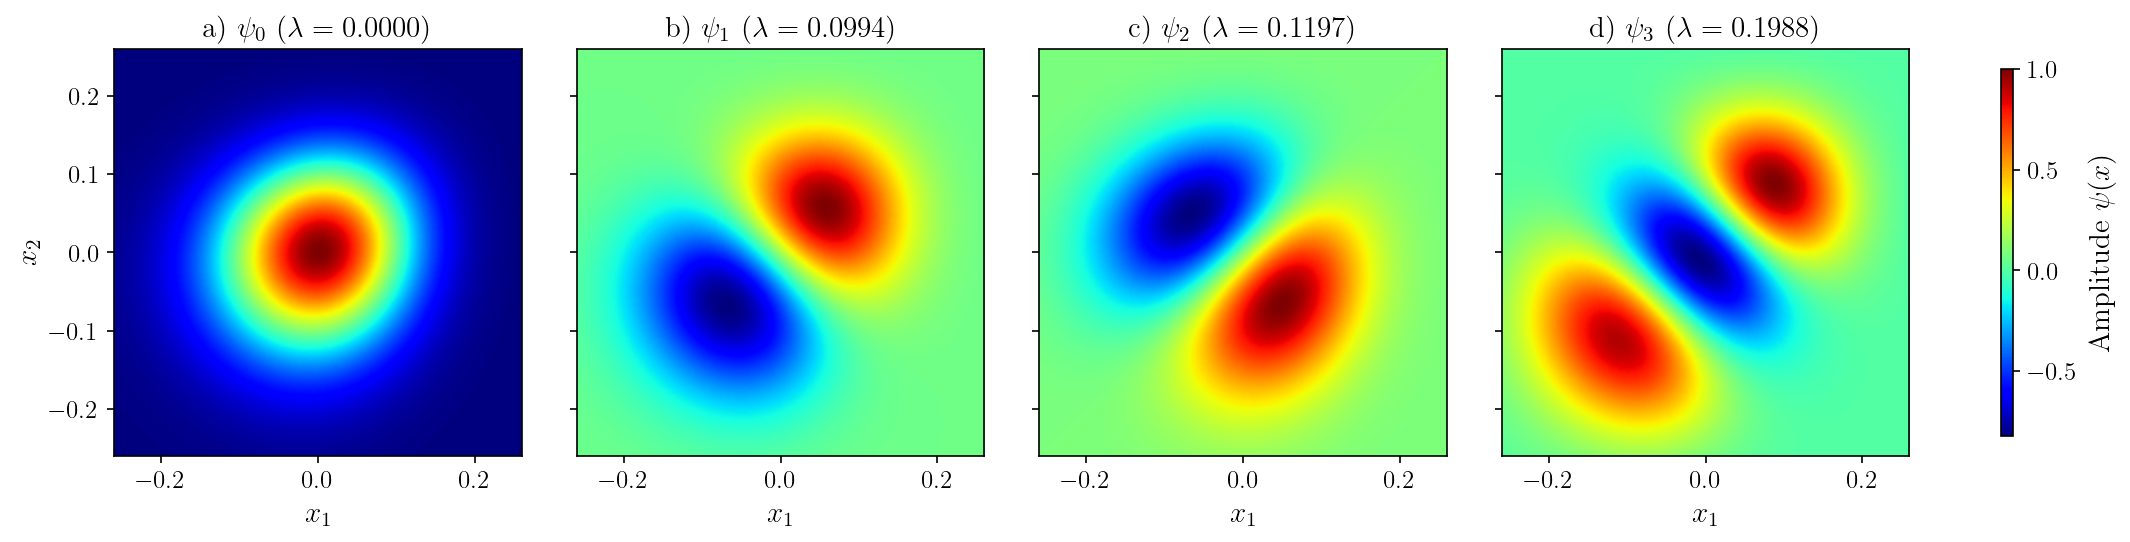

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import os
import matplotlib as mpl

# -------------------------------------------------------------------------
# 0. Configuration & Parameters
# -------------------------------------------------------------------------
if not os.path.exists('figures'): os.makedirs('figures')

def savefig_pdf(fname):
    if not fname.lower().endswith(".pdf"):
        fname = 'figures/' + fname + ".pdf"
    plt.savefig(fname)
    print(f"Saved: {fname}")

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "figure.dpi": 150,
    "savefig.bbox": "tight",
})

# --- Physics Parameters (Matched to your Simulation) ---
m1, m2 = 1.0, 1.0
c_damp = 100.0      # High damping
k1, k2 = 10.0, 10.0
kc     = 1.0

# Nonlinear coefficients
beta1, beta2   = 10.0, 10.0
alpha1, alpha2 = 10.0, 10.0
delta2         = 1.0 

# Noise Intensity
D_val = 4.0

# --- Grid Settings ---
# Matched to your simulation to ensure features fit
L_phys = 0.26  
N_grid = 191   
extent = [-L_phys, L_phys, -L_phys, L_phys]

# -------------------------------------------------------------------------
# 1. Physics Modules
# -------------------------------------------------------------------------
def get_potential(x1, x2):
    """
    Constructs the potential surface U(x1, x2).
    Matches the formulation in your running code.
    """
    # 1. Local Potentials
    # Integral(k x + beta x^2 + alpha x^3) -> 1/2 k x^2 + 1/3 beta x^3 + 1/4 alpha x^4
    U_local_1 = 0.5*k1*x1**2 + (1.0/3.0)*beta1*x1**3 + 0.25*alpha1*x1**4
    U_local_2 = 0.5*k2*x2**2 + (1.0/3.0)*beta2*x2**3 + 0.25*alpha2*x2**4
    
    # 2. Coupling Potential
    # Linear: 1/2 kc (diff)^2
    # Nonlinear: 1/4 delta (diff)^4
    diff = x2 - x1
    U_coupling = 0.5*kc*(diff)**2 + 0.25*delta2*(diff)**4
    
    return U_local_1 + U_local_2 + U_coupling

# -------------------------------------------------------------------------
# 2. Solver Routine
# -------------------------------------------------------------------------
def solve_eigenfunctions():
    print("\n" + "="*40)
    print("   SPECTRAL SOLVER (Eigenfunctions)")
    print(f"   Grid: {N_grid}x{N_grid}, L={L_phys}")
    print("="*40)

    # 1. Grid Setup
    x = np.linspace(-L_phys, L_phys, N_grid)
    hx = x[1] - x[0]
    X1, X2 = np.meshgrid(x, x, indexing='ij')
    
    # 2. Physics Scaling (Smoluchowski)
    # D_eff = D / c^2
    D_eff = D_val / (c_damp**2)
    
    # Scaled Potential: Phi = U / c
    U_grid = get_potential(X1, X2)
    Phi = U_grid / c_damp
    Phi -= np.min(Phi)
    
    # 3. Supersymmetric Hamiltonian Construction
    
    # -- Gradients of Phi --
    dPhi_dx1 = np.gradient(Phi, hx, axis=0).ravel()
    dPhi_dx2 = np.gradient(Phi, hx, axis=1).ravel()
    
    # W_k = (1 / 2*sqrt(D)) * dPhi/dx_k
    W1 = dPhi_dx1 / (2.0 * np.sqrt(D_eff))
    W2 = dPhi_dx2 / (2.0 * np.sqrt(D_eff))
    
    # -- Derivative Operator (Forward Difference) --
    N = N_grid
    ones = np.ones(N)
    
    # Forward difference stencil (Sparse)
    D_1D = sp.diags([-ones, ones], [0, 1], shape=(N, N)) / hx
    I = sp.eye(N)
    
    # -- Construct 2D Operators --
    # A_x (Axis 0)
    D_x_2D = sp.kron(D_1D, I) 
    A_1 = np.sqrt(D_eff) * D_x_2D + sp.diags(W1)
    
    # A_y (Axis 1)
    D_y_2D = sp.kron(I, D_1D) 
    A_2 = np.sqrt(D_eff) * D_y_2D + sp.diags(W2)
    
    # -- Assemble Hamiltonian --
    print("[Spec] Assembling Sparse Hamiltonian...")
    H_mat = A_1.T @ A_1 + A_2.T @ A_2
    
    print("[Spec] Solving Eigenproblem (Sparse Shift-Invert)...")
    # sigma=1e-7 targets values extremely close to 0.0 (Ground state)
    vals, vecs = spla.eigsh(H_mat, k=4, sigma=1e-7, which='LM')
    
    # Sort just in case
    idx = np.argsort(vals)
    vals = vals[idx]
    vecs = vecs[:, idx]
    
    print(f"[Spec] First 4 Eigenvalues: {vals}")
    return vals, vecs

# -------------------------------------------------------------------------
# 3. Main Plotting
# -------------------------------------------------------------------------
if __name__ == "__main__":
    vals, vecs = solve_eigenfunctions()
    
    fig, ax = plt.subplots(1, 4, figsize=(14, 3.5), constrained_layout=True)
    letters = ['a)', 'b)', 'c)', 'd)']
    
    for i in range(4):
        psi = vecs[:, i].reshape(N_grid, N_grid)
        
        # --- Post-Processing ---
        # 1. Enforce sign convention: Max peak is positive
        if np.max(psi) < np.abs(np.min(psi)):
            psi *= -1
    
        # 2. Clean Ground State: 
        # Analytically, Psi_0 must be strictly positive (Perron-Frobenius).
        if i == 0:
            psi = np.abs(psi)
            
        # 3. Normalize for plotting
        psi /= np.max(np.abs(psi))
            
        # Plot
        im = ax[i].imshow(psi.T, origin='lower', extent=extent, 
                          cmap='jet', interpolation='bilinear')
        
        ax[i].set_title(f"{letters[i]} $\psi_{i}$ ($\lambda={vals[i]:.4f}$)")
        ax[i].set_xlabel('$x_1$')
        if i == 0:
            ax[i].set_ylabel('$x_2$')
        else:
            ax[i].set_yticklabels([])
            ax[i].set_ylabel('')
    
    # Add Colorbar
    cbar = fig.colorbar(im, ax=ax, location='right', shrink=0.9, aspect=30)
    cbar.set_label('Amplitude $\psi(x)$')
    
    # Add System Info
    savefig_pdf("Figure_11")
    plt.show()